# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*


I would like to report here ...

In [22]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import yeojohnson

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



# 1.Data Validation

In this notebook, the goal is to build a model that can correctly predict popular recipes 80% of the time, while also avoiding errors in identifying less popular recipes.

To start, I'll check the data quality by handling any missing values and making sure each column has the right data type.

Next, I’ll explore the data to gather useful insights. Using these insights, I’ll create a machine learning model and compare its results with baseline models.

Finally, I’ll align the solution with business goals and suggest recommendations to help drive business success.

In [23]:
# Reading the raw data from the file
recipe_df = pd.read_csv("recipe_site_traffic_2212.csv")

# checking the fist 5 row (head) of the data
recipe_df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [24]:
# Getting summary statistics of the data
recipe_df.describe(include= 'all')

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
count,947.000000,895.000000,895.000000,895.000000,895.000000,947,947,574
unique,NaN,NaN,NaN,NaN,NaN,11,6,1
top,NaN,NaN,NaN,NaN,NaN,Breakfast,4,High
freq,NaN,NaN,NaN,NaN,NaN,106,389,574
mean,474.000000,435.939196,35.069676,9.046547,24.149296,NaN,NaN,NaN
std,273.519652,453.020997,43.949032,14.679176,36.369739,NaN,NaN,NaN
min,1.000000,0.140000,0.030000,0.010000,0.000000,NaN,NaN,NaN
25%,237.500000,110.430000,8.375000,1.690000,3.195000,NaN,NaN,NaN
50%,474.000000,288.550000,21.480000,4.550000,10.800000,NaN,NaN,NaN
75%,710.500000,597.650000,44.965000,9.800000,30.200000,NaN,NaN,NaN


In [25]:
#finding the number of duplicated recipes
recipe_df.duplicated(subset='recipe').sum()

0

Since there are no duplicates, I don't need to remove rows. My next step is to examine the columns of the data to make sure they align with the name and expected data type as instruction.

## 1.1 Data Type and Statistics
I have noticed that the data types are not correct so I converted them to approperiate ones as requested. I also noticed that the column 'servings' has non integer values so I replaced them with interger. for example replaced '4 as a snack' with '4' 

In [26]:
# Reading data types and converting to appropariate ones
print(recipe_df.dtypes)
print('\nAfter data type conversion:\n\n')

recipe_df_cat = recipe_df.copy()
categories = ['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken Breast', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert' , 'Chicken']

# Convering 'category' column to category data type
recipe_df_cat['category'] = pd.Categorical(recipe_df['category'], categories=categories)



# Converting servings to numerical data type
recipe_df_cat['servings'] = recipe_df_cat['servings'].replace('4 as a snack', 4)
recipe_df_cat['servings'] = recipe_df_cat['servings'].replace('6 as a snack', 6)
recipe_df_cat['servings'] = pd.to_numeric(recipe_df_cat['servings'], errors='ignore')
print(recipe_df_cat.dtypes)

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

After data type conversion:


recipe             int64
calories         float64
carbohydrate     float64
sugar            float64
protein          float64
category        category
servings           int64
high_traffic      object
dtype: object


In [27]:
#checking the values of category column
print(recipe_df_cat['category'].value_counts())

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64


I noticed that there are separate categories for 'Chicken' and 'Chicken Breast' in the data, and I decided not to merge them for two reasons. First, merging could introduce bias by increasing the number of records in the 'Chicken' category, potentially skewing the model towards a popular but less impactful category. Second, I believe there may be meaningful differences between 'Chicken' and 'Chicken Breast' in terms of customer preference. For example, people often prefer boneless meat, or they might avoid chicken breast due to its tendency to be dry. I think these distinctions could actually affect the model’s ability to predict popular recipes, so I decided to keep 'Chicken' and 'Chicken Breast' separate.

## 1.2 Missing Values Handling


In [28]:
#checking missing numbers for each columns
print(recipe_df_cat.isnull().sum())


recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64


Our target variable is high_traffic, which is recorded as either "High" or "NA". To make a prediction, I converted this column into a boolean format, indicating whether the traffic is "High" or "Unknown". In this case, True represents "High" traffic, and False represents that "High" traffic was not observed. It's important to note that False does not necessarily indicate low traffic—it simply means that high traffic was not detected.

In [29]:
recipe_df_cat['high_traffic'] = recipe_df_cat['high_traffic'].apply(lambda x : True if x == 'High' else False)
print(recipe_df_cat.isnull().sum())
#checking the values of high_traffic column

print("\n High traffic value count:\n",recipe_df_cat['high_traffic'].value_counts())

recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

 High traffic value count:
 True     574
False    373
Name: high_traffic, dtype: int64


In [30]:
# Calculating missing rate
missing_rate = max(recipe_df_cat.isnull().sum())/len(recipe_df) * 100
print("missing rate %: ", missing_rate)


# Showing all rows with missing values
recipe_df_cat[recipe_df_cat.isnull().any(axis=1)]


missing rate %:  5.4910242872228086


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,True
23,24,NaN,NaN,NaN,NaN,Meat,2,False
48,49,NaN,NaN,NaN,NaN,Chicken Breast,4,False
82,83,NaN,NaN,NaN,NaN,Meat,4,True
89,90,NaN,NaN,NaN,NaN,Pork,6,True
116,117,NaN,NaN,NaN,NaN,Chicken Breast,6,True
121,122,NaN,NaN,NaN,NaN,Dessert,2,True
136,137,NaN,NaN,NaN,NaN,One Dish Meal,2,True
149,150,NaN,NaN,NaN,NaN,Potato,2,True
187,188,NaN,NaN,NaN,NaN,Pork,4,True


Since the missing rate is only 5.4%, which is relatively low, and the missing values are scattered across entire rows, imputation would not be a sensible approach. With such a small dataset, imputing missing values could introduce biases and reduce the accuracy of the model. Therefore, I have decided to drop the rows with missing data

Now we are ready for exploratory analysis

# 2.Explorary Analysis

I decided to set the recipe column as the index since each value is unique and represents a specific recipe. The numbers in this column don't carry any statistical meaning—recipe 5, for example, has no meaningful relationship or hierarchy over recipe 4

In [31]:
# setting recipe coulmn as index
recipe_df_cat = recipe_df_cat.set_index('recipe')
#dropping missing values
recipe_df_cat = recipe_df_cat.dropna().reset_index(drop=True)
print(recipe_df_cat.isnull().sum())

calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64


In [32]:
#checking the summary of dataframe's structure
recipe_df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      895 non-null    float64 
 1   carbohydrate  895 non-null    float64 
 2   sugar         895 non-null    float64 
 3   protein       895 non-null    float64 
 4   category      895 non-null    category
 5   servings      895 non-null    int64   
 6   high_traffic  895 non-null    bool    
dtypes: bool(1), category(1), float64(4), int64(1)
memory usage: 37.2 KB


In [33]:
#generating descriptive statistic for each columns
recipe_df_cat.describe()

,calories,carbohydrate,sugar,protein,servings
count,895.000000,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296,3.458101
std,453.020997,43.949032,14.679176,36.369739,1.735979
min,0.140000,0.030000,0.010000,0.000000,1.000000
25%,110.430000,8.375000,1.690000,3.195000,2.000000
50%,288.550000,21.480000,4.550000,10.800000,4.000000
75%,597.650000,44.965000,9.800000,30.200000,4.000000
max,3633.160000,530.420000,148.750000,363.360000,6.000000


## 2.1 Data Skewness and Outliners
Analysing the descriptive statistics, it's evident that there is a notable standard deviation, particularly in columns related to calories and nutritional components.
Additionally, the quantile values indicate the presence of outliers, contributing to skewness in the distribution. 

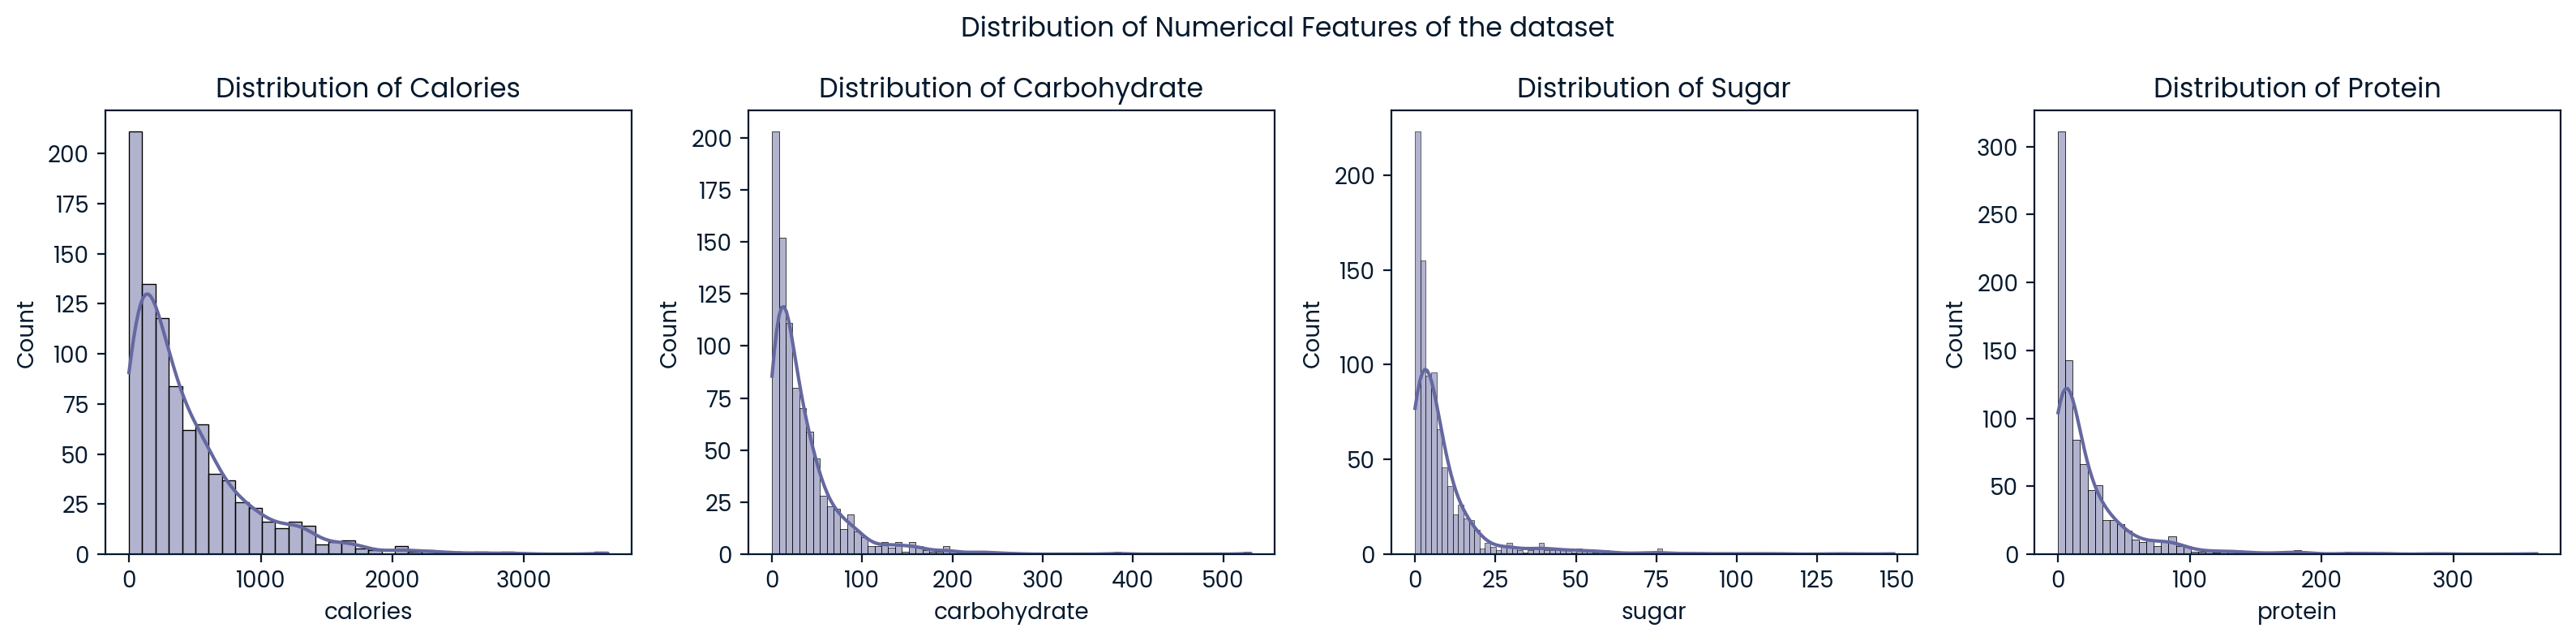

In [34]:
# plotting the distribution of numerical columns of the dataset
#specifying the numerical columns to plot
numerical_columns =  recipe_df_cat.select_dtypes(include='float').columns

plt.figure(figsize=(16, 4))

#iterating over each column and create a bar plot
for i, column in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    sns.histplot(data=recipe_df_cat, x=column, kde=True)
    plt.title(f"Distribution of {column.capitalize()}")

plt.suptitle('Distribution of Numerical Features of the dataset')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of Calories')

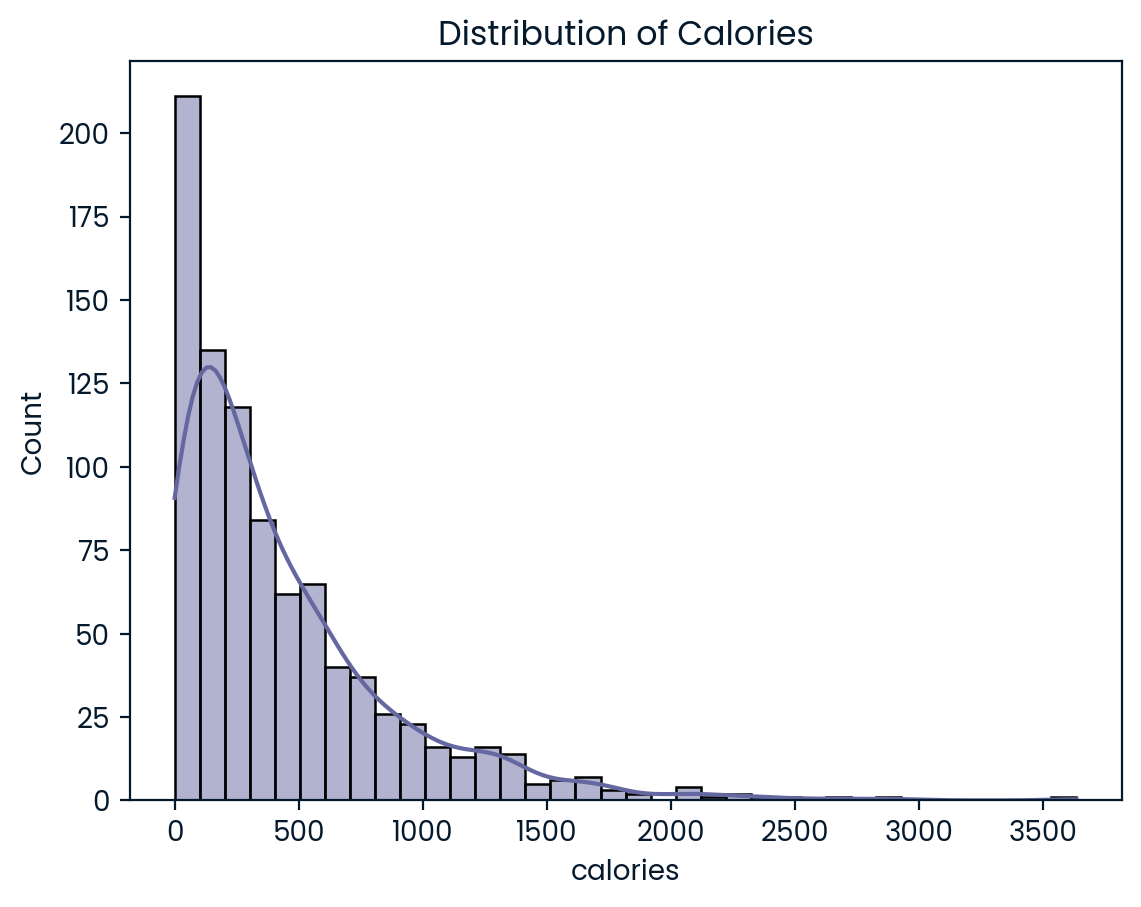

In [35]:
# having a closer look
sns.histplot(data= recipe_df_cat, x = 'calories', kde = True)
plt.title('Distribution of Calories')

Text(0.5, 1.0, 'Distribution of Carbohydrate')

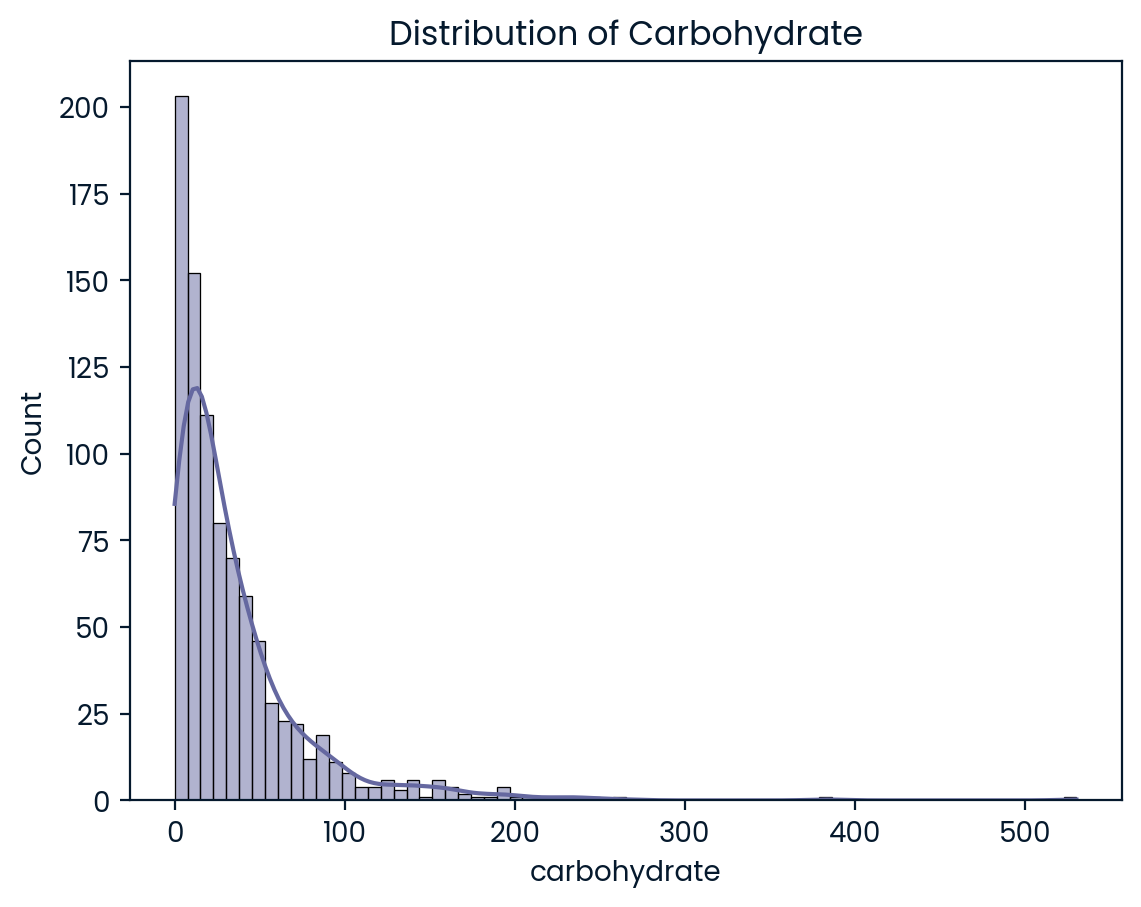

In [36]:
sns.histplot(data= recipe_df_cat, x = 'carbohydrate', kde = True)
plt.title('Distribution of Carbohydrate')

Text(0.5, 1.0, 'Distribution of Sugar')

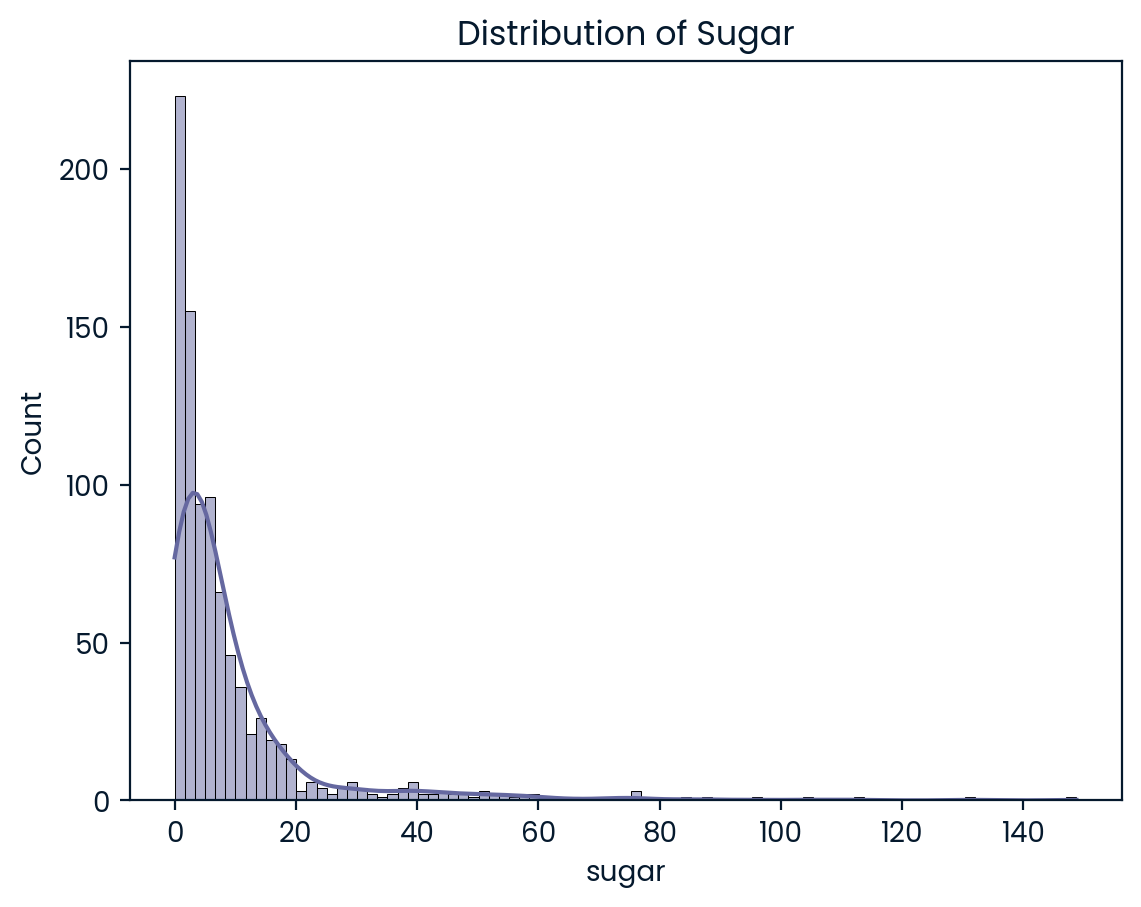

In [37]:
sns.histplot(data= recipe_df_cat, x = 'sugar', kde = True)
plt.title('Distribution of Sugar')

Text(0.5, 1.0, 'Distribution of Protein')

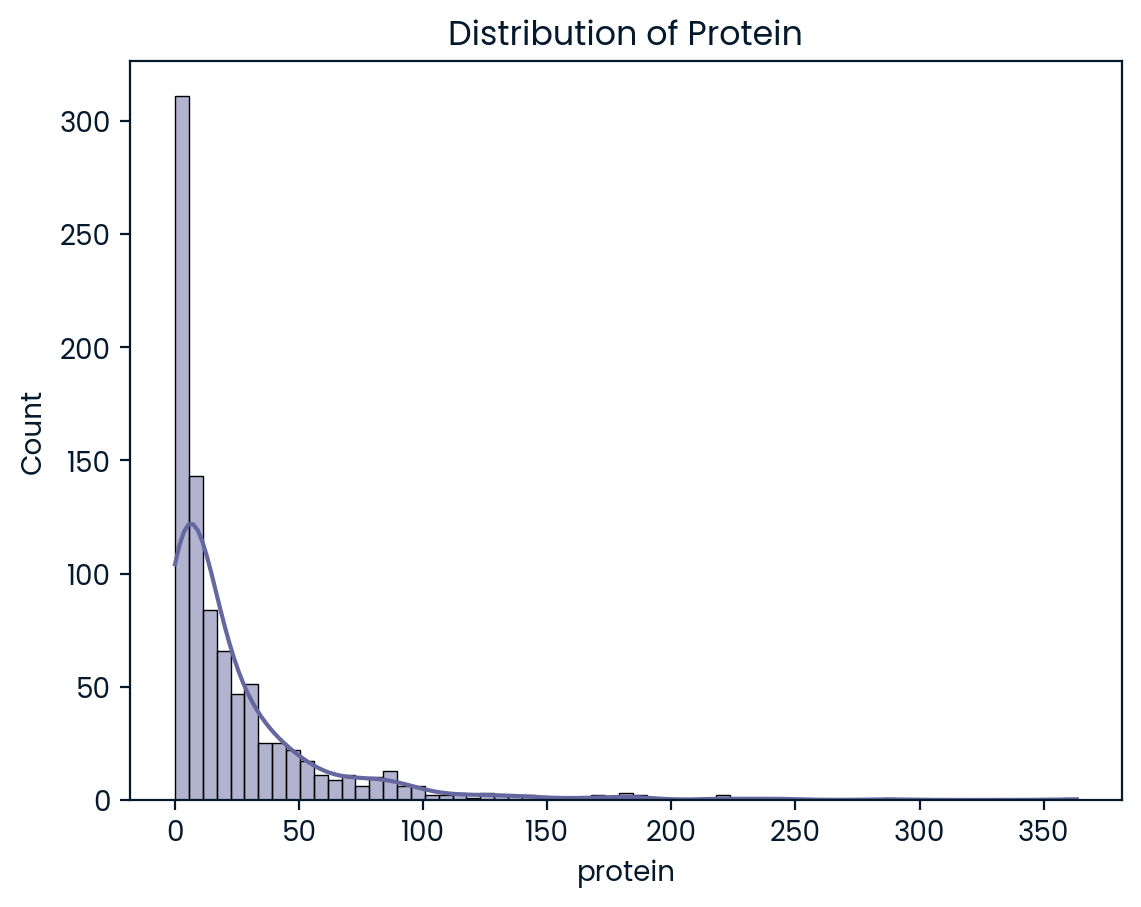

In [38]:
sns.histplot(data= recipe_df_cat, x = 'protein', kde = True)
plt.title('Distribution of Protein')

Including Kernel Density Estimation (KDE) in the plots creates a smooth curve that highlights the underlying data distribution.

Observing the plots, we can see that the dataset mainly consists of lower values for calories and other nutritional components in foods or beverages. The histograms confirm our previous observation about skewness: all the numerical columns display a right-skewed distribution.

To further illustrate this distribution, we’ll now present it using box plots.

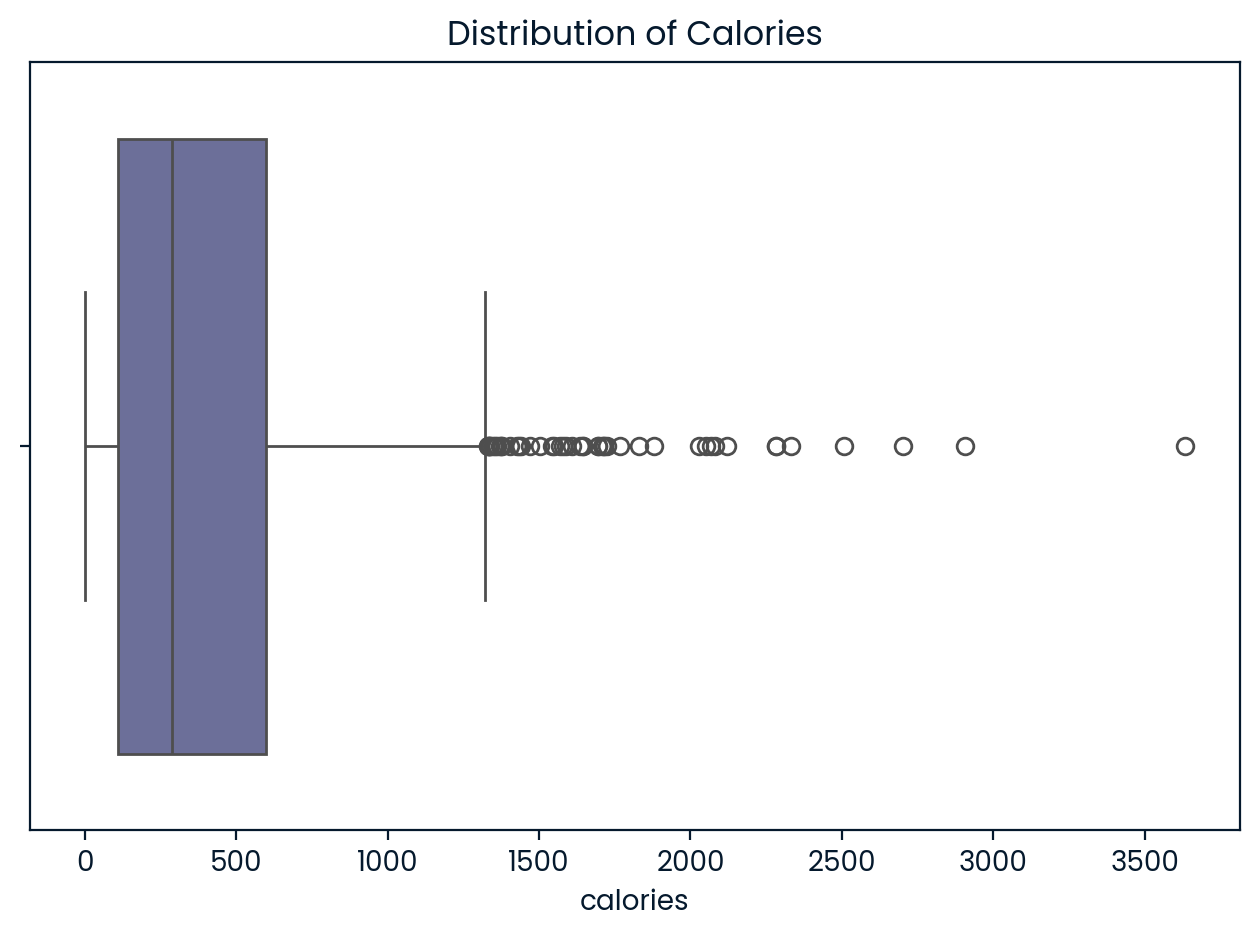

In [39]:
sns.boxplot(data= recipe_df_cat, x = 'calories')
plt.title('Distribution of Calories')
plt.tight_layout()
plt.show()

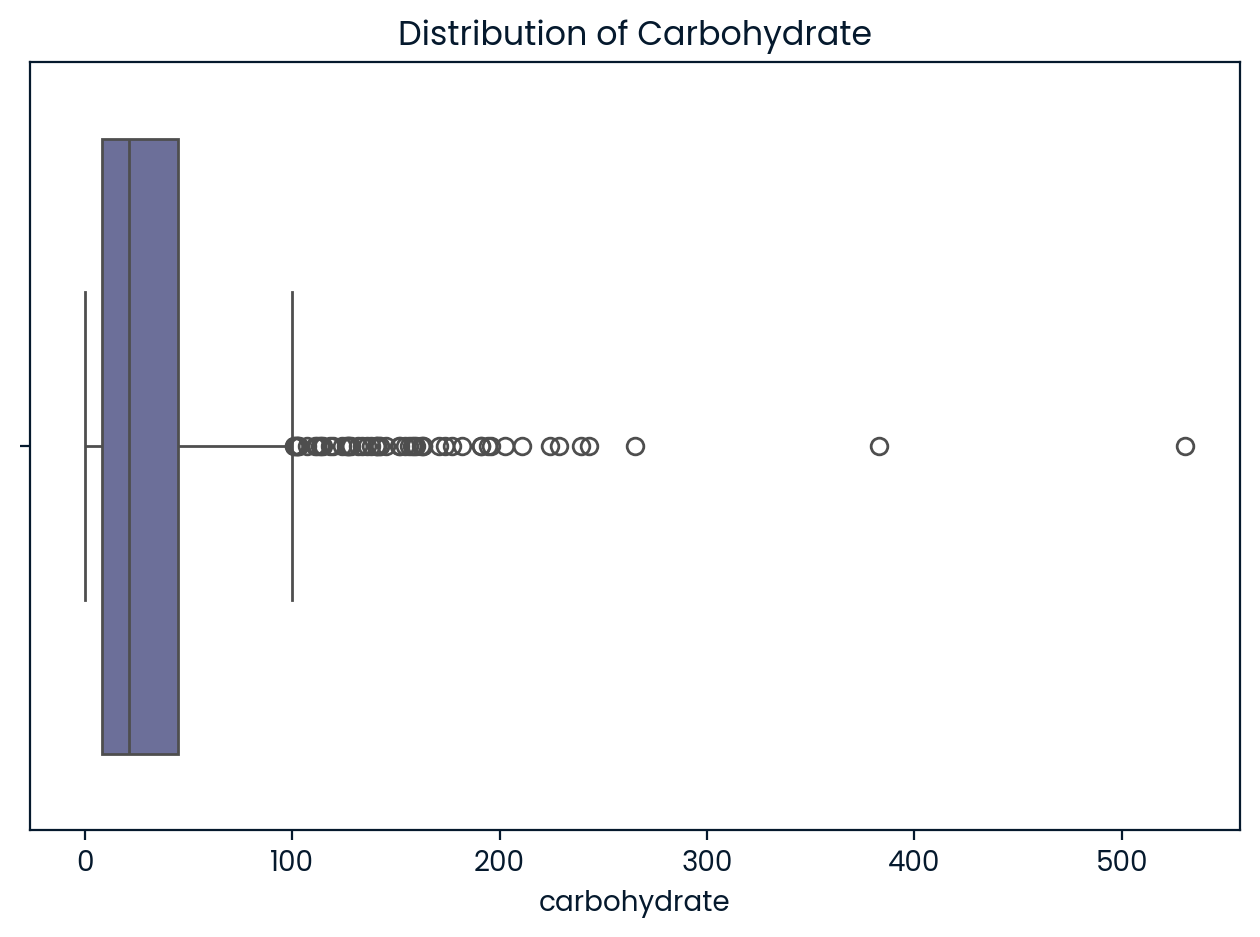

In [40]:
sns.boxplot(data= recipe_df_cat, x = 'carbohydrate')
plt.title('Distribution of Carbohydrate')
plt.tight_layout()
plt.show()

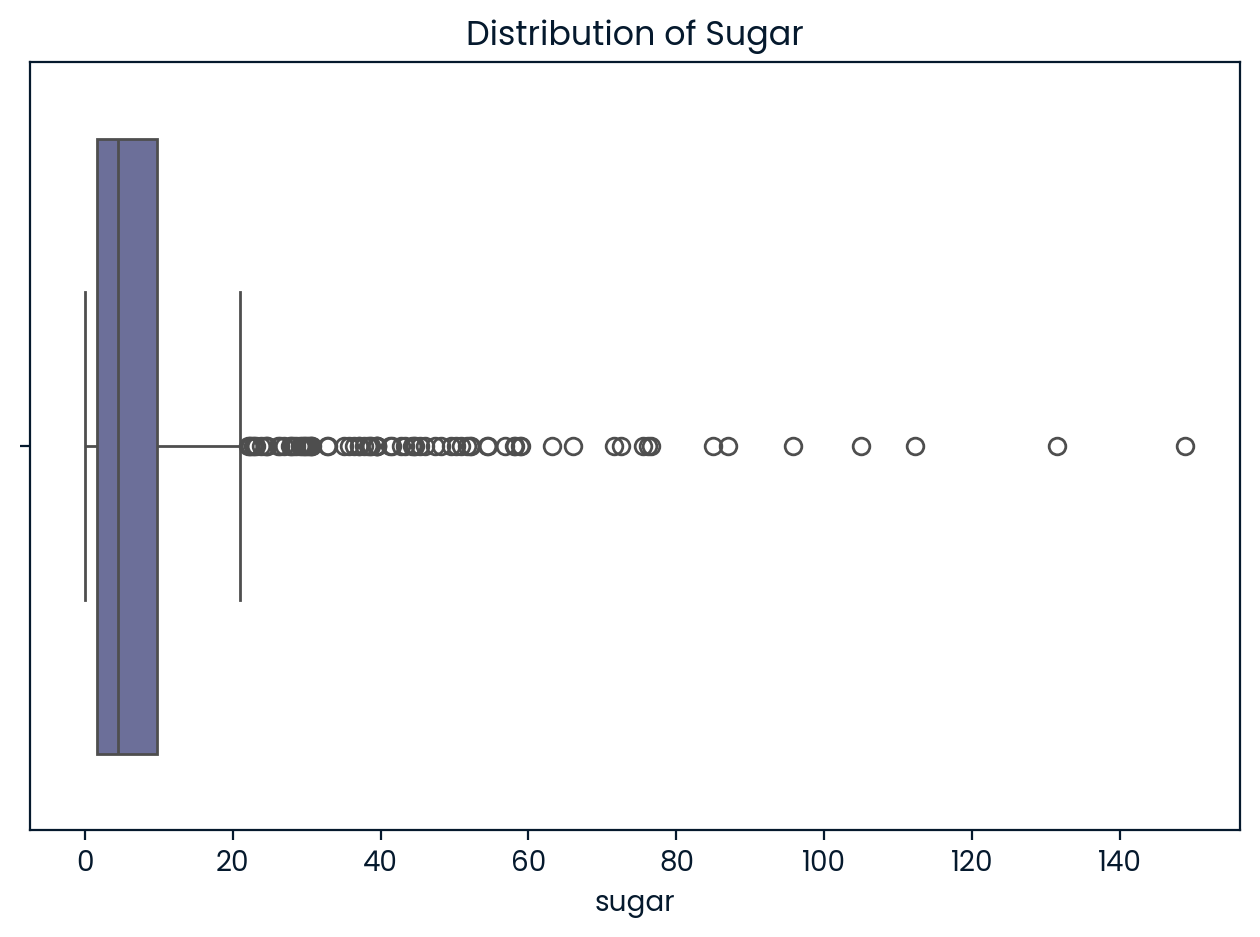

In [41]:
sns.boxplot(data= recipe_df_cat, x = 'sugar')
plt.title('Distribution of Sugar')
plt.tight_layout()
plt.show()

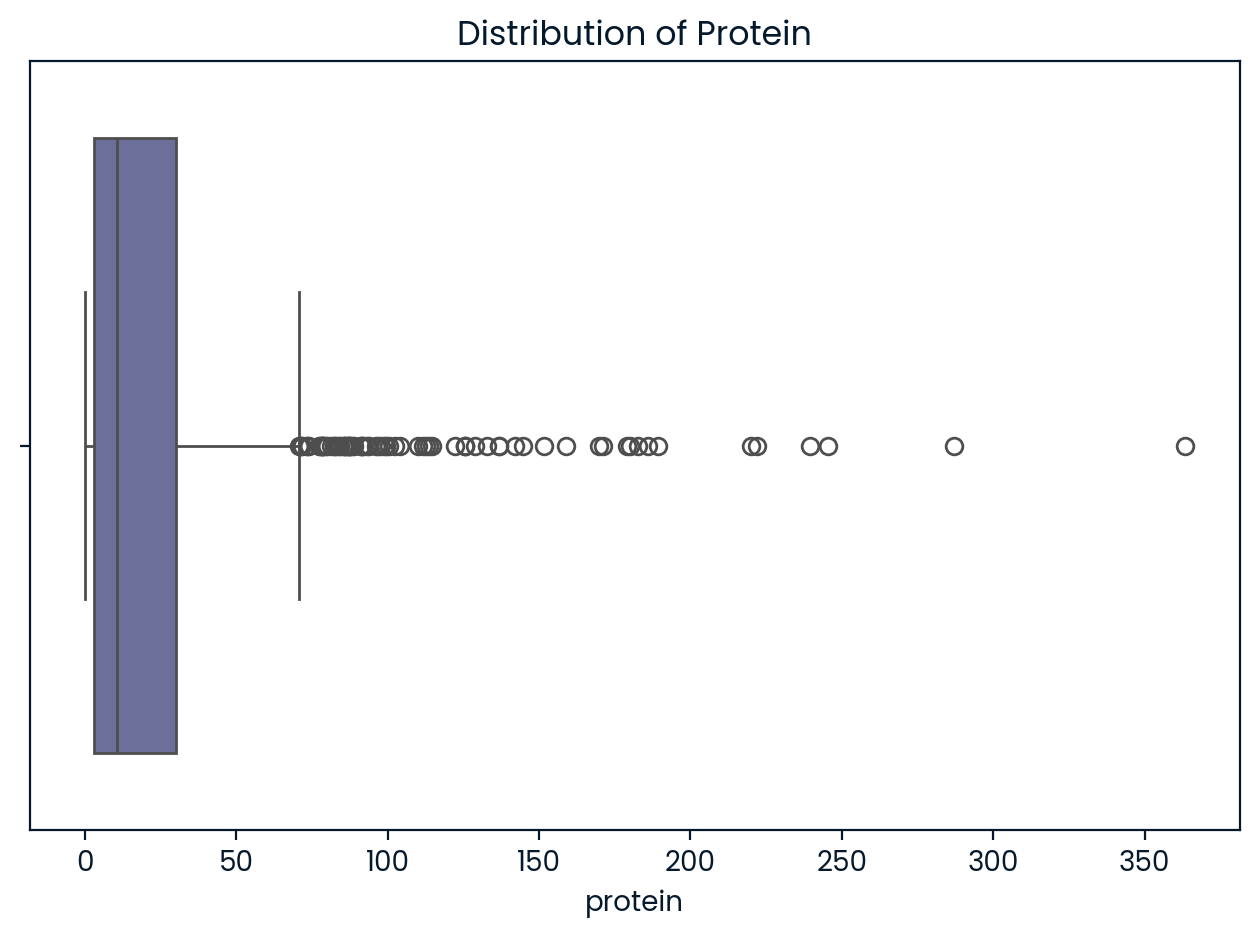

In [42]:
sns.boxplot(data= recipe_df_cat, x = 'protein')
plt.title('Distribution of Protein')
plt.tight_layout()
plt.show()

The plots above confirm the presence of outliers, the right-skewed distribution of these columns, and the need for methods to address both the skewness and the outliers effectively.

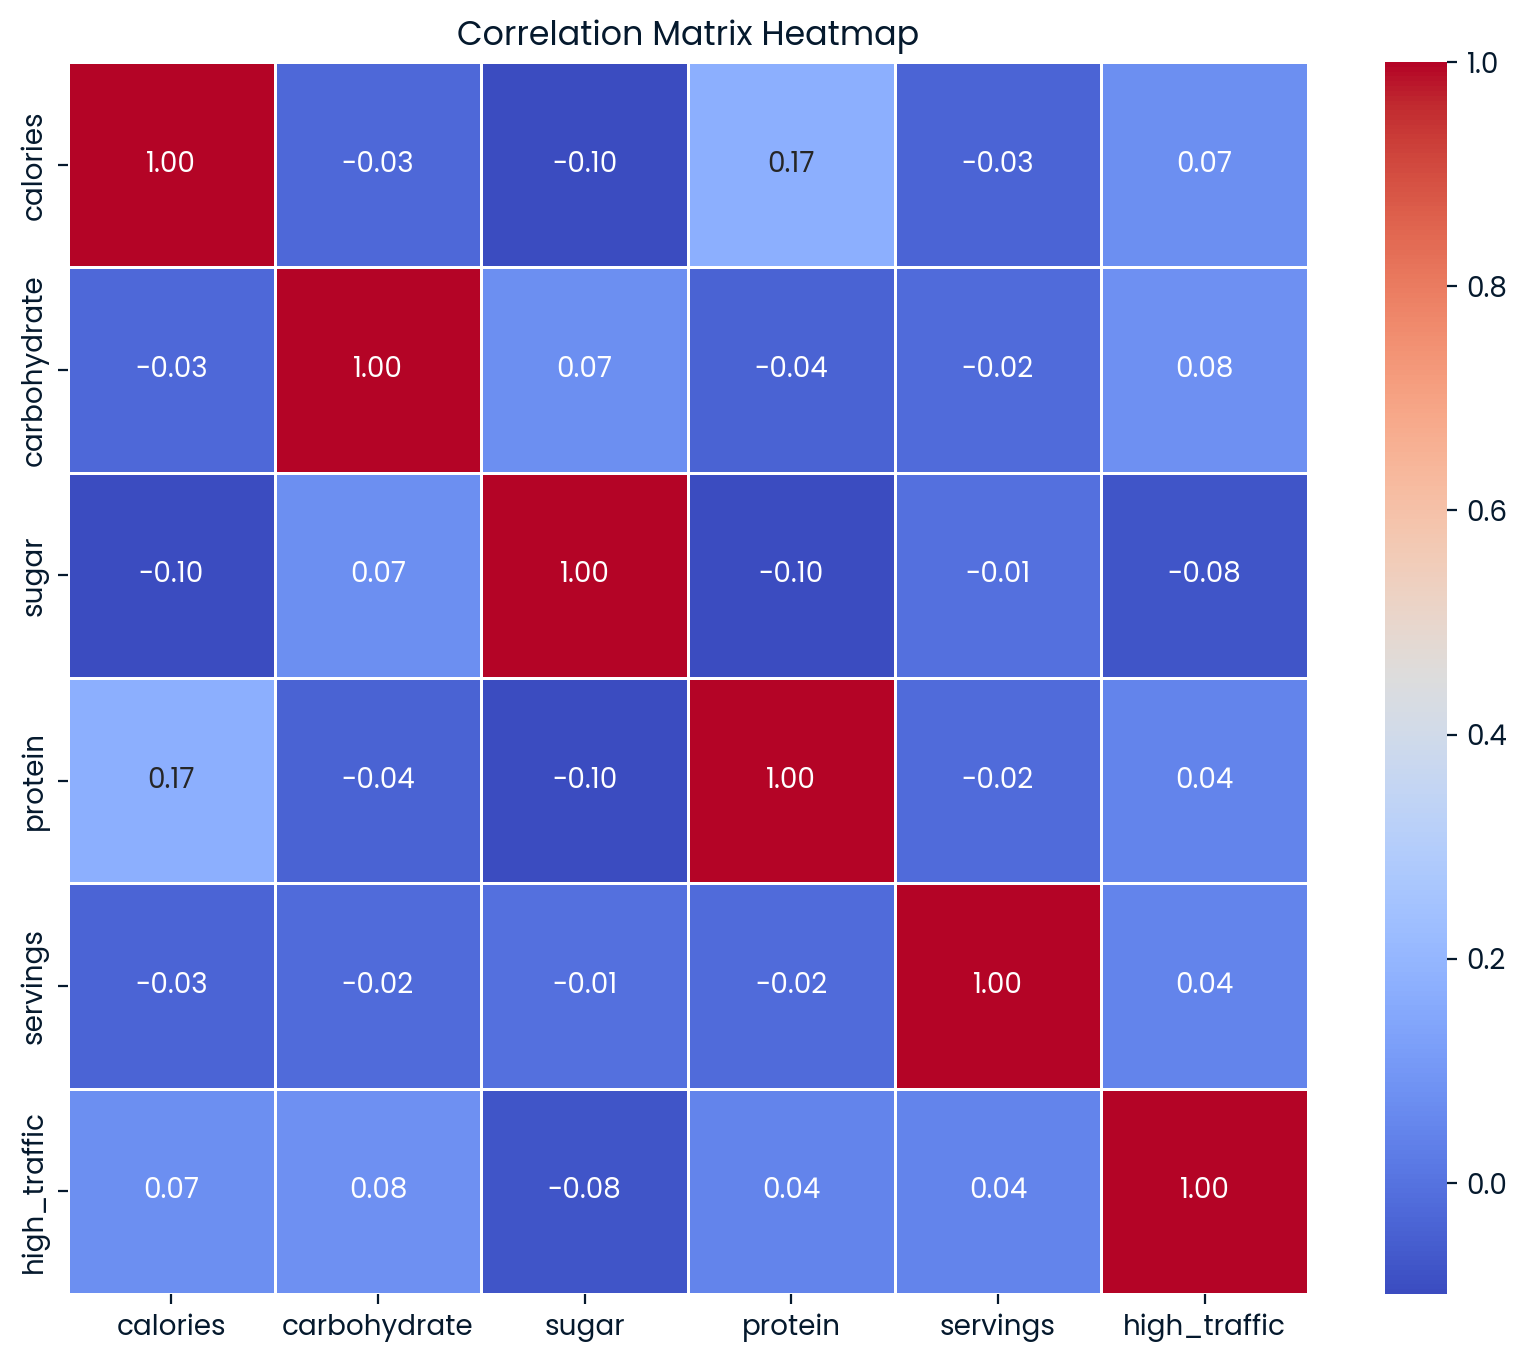

In [43]:
# Plotting the correlation between features of data
# Compute correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = recipe_df_cat.corr()
# Getting the Upper Triangle of the co-relation matrix
matrix_mask = np.triu(corr_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5 ) # , mask = matrix_mask


plt.title('Correlation Matrix Heatmap')
plt.show()

Since the data doesn’t show strong correlations between columns, we can conclude that the information is largely independent and non-redundant.

## 2.2 Data Imbalance
I have a deeper look at dataset to observe it's distribution across categorical data and thier relation to eachother

Breakfast         106
Chicken Breast     94
Beverages          92
Potato             83
Lunch/Snacks       82
Vegetable          78
Dessert            77
Meat               74
Pork               73
Chicken            69
One Dish Meal      67
Name: category, dtype: int64


Text(0.5, 1.0, 'Count of high traffic recipe by servings')

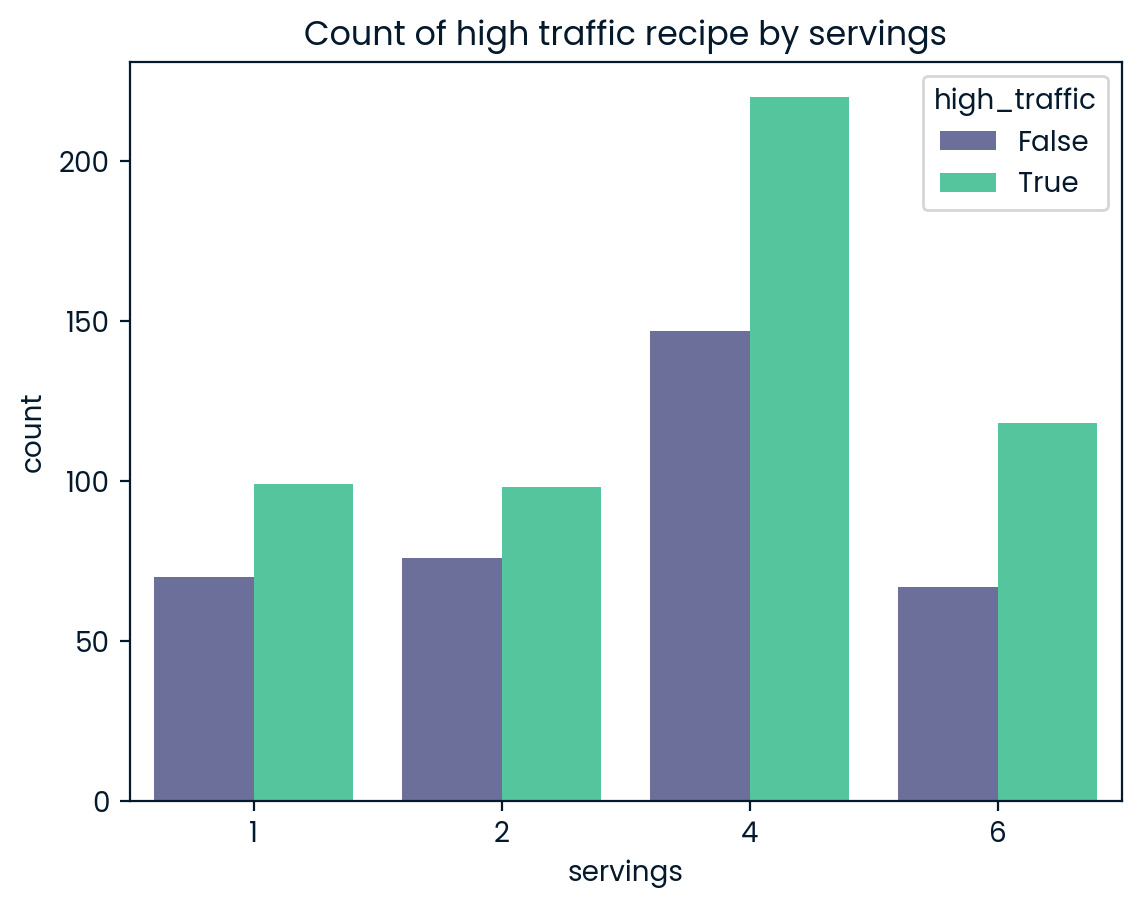

In [44]:
# Looking into imbalanceness of categories

print(recipe_df_cat['category'].value_counts())

sns.countplot( x = 'servings', hue='high_traffic', data = recipe_df_cat)
plt.title("Count of high traffic recipe by servings")

The plot above shows that servings of 4 and 6 are more frequently observed when high traffic is present.

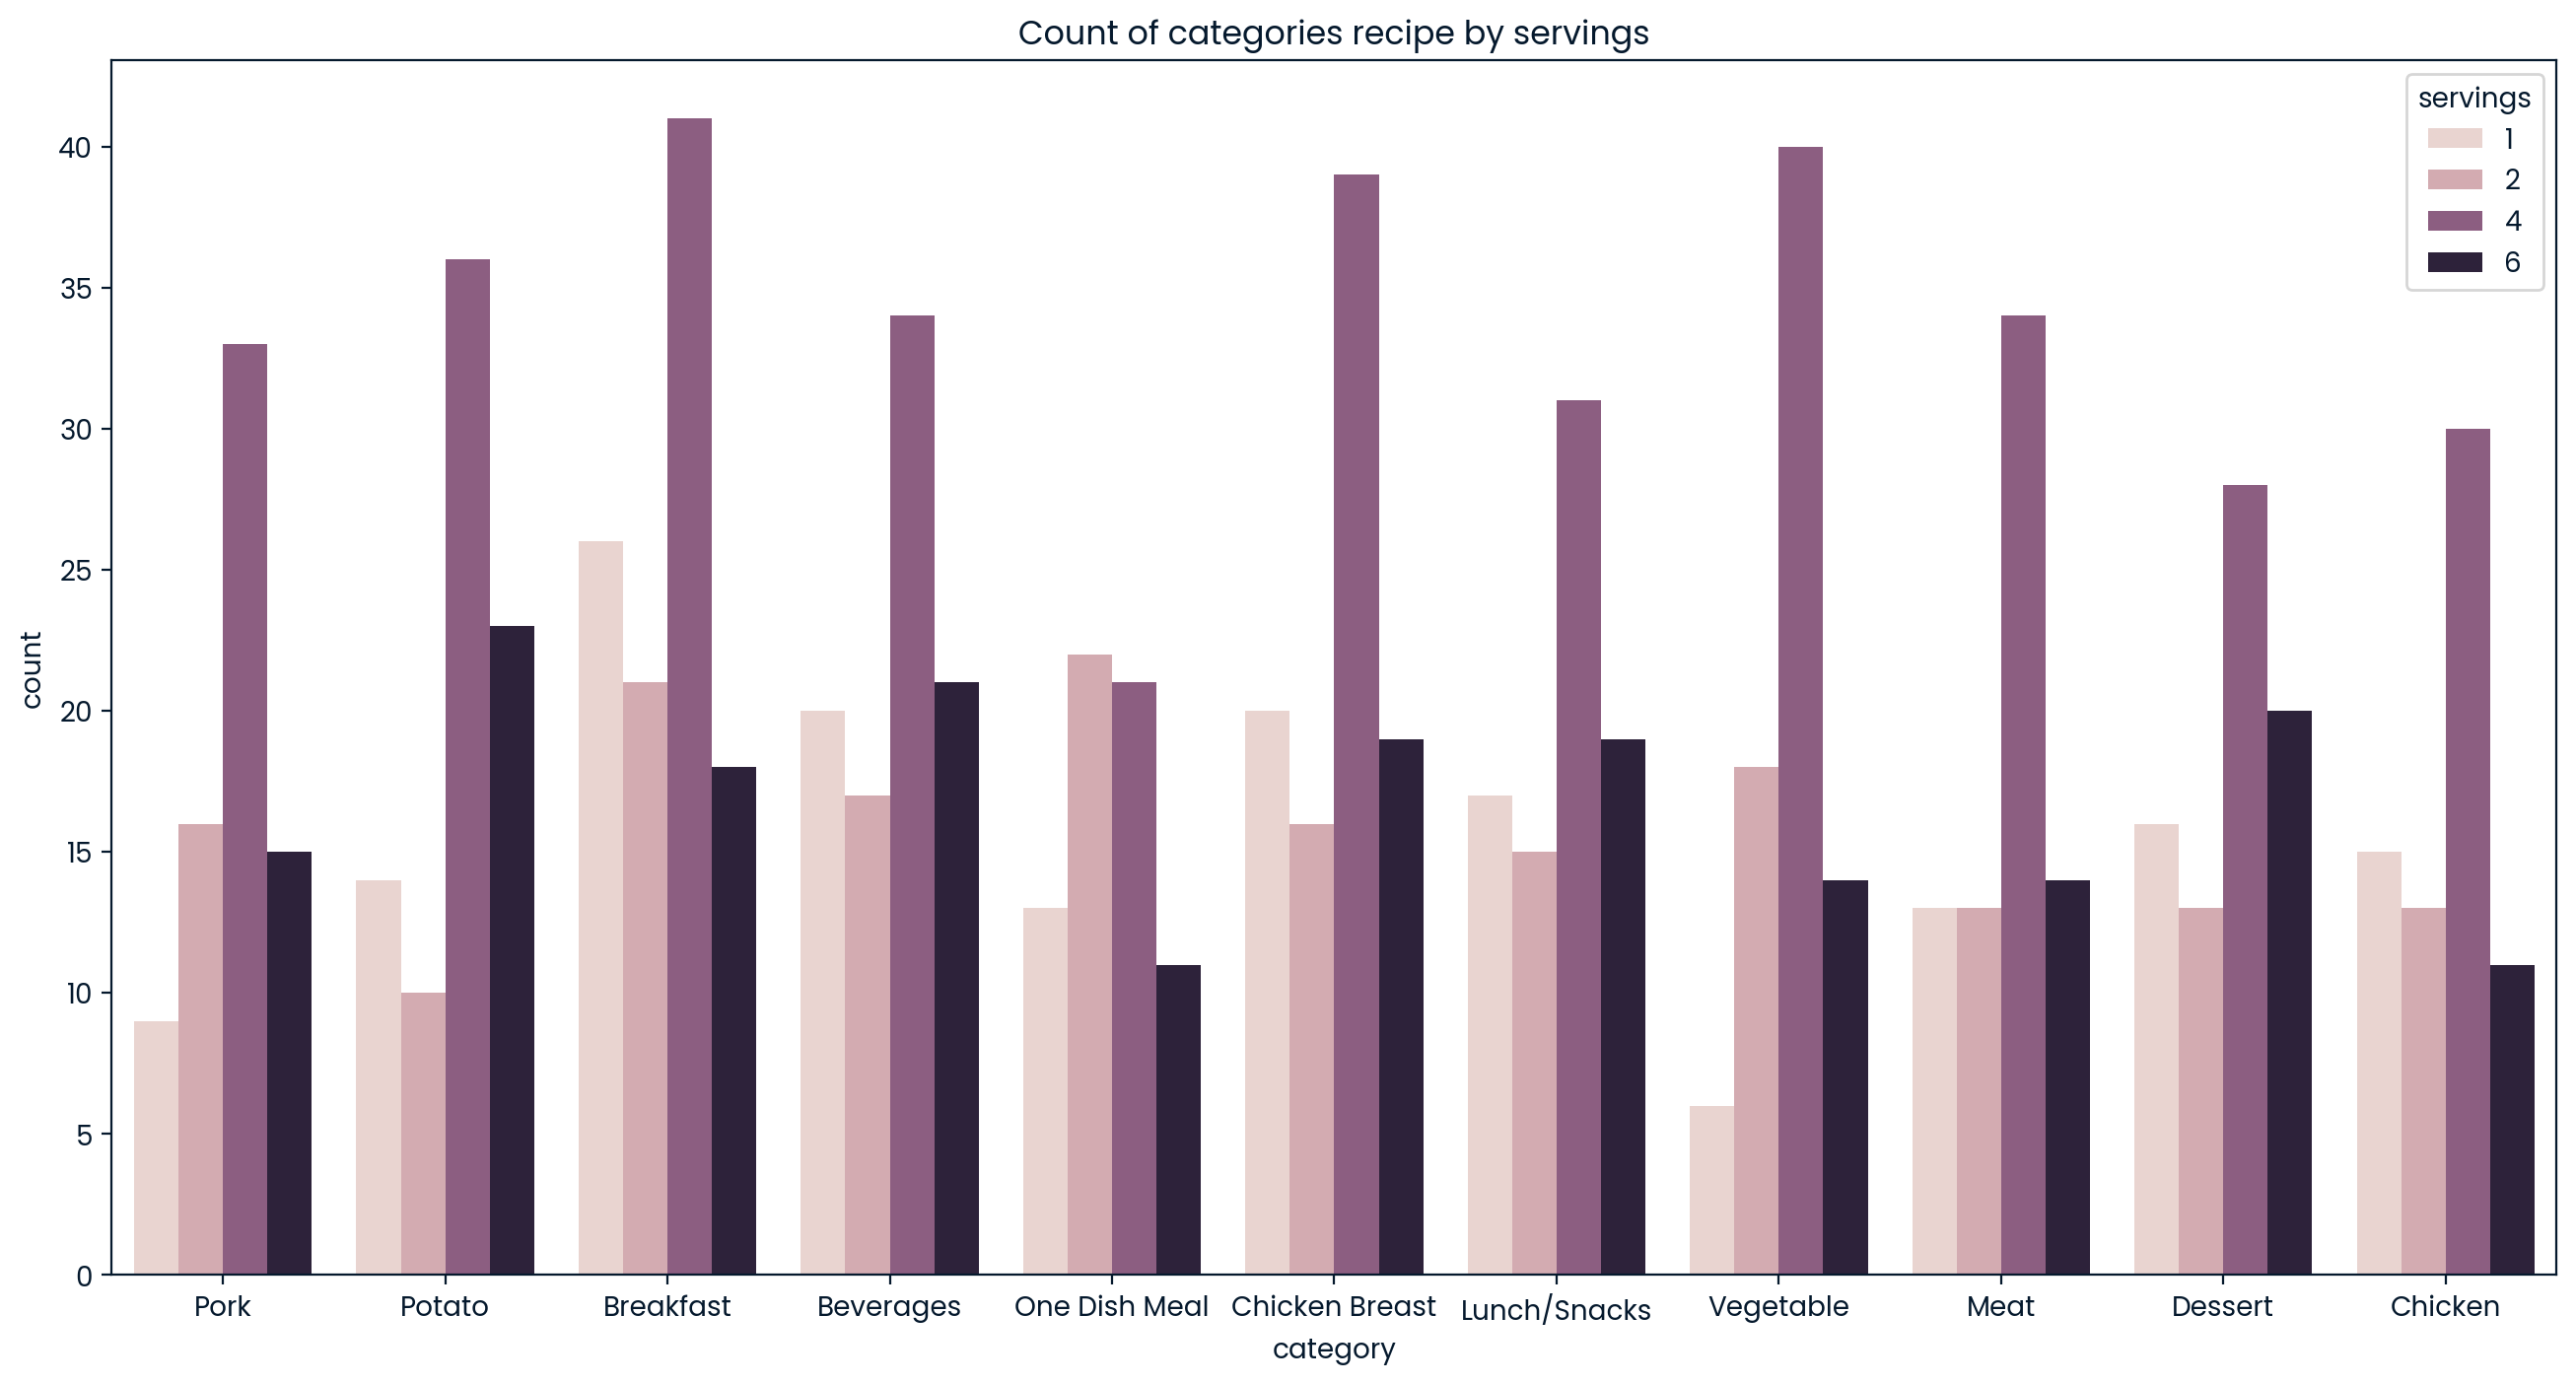

In [45]:
# plotting high traffic vs serving

plt.figure(figsize=(16, 8))
sns.countplot( x = 'category', hue='servings', data = recipe_df_cat)
plt.title("Count of categories recipe by servings")
plt.show()

The graph above illustrates the distribution of servings across each category. It is evident that there is an imbalance in the distribution of servings among the categories. For example, chicken has a high frequency in serving 4, while vegetables show a low count in serving 1. I need to consider this imbalance in later analyses because it poses a risk of skewing the model's conclusions. The observed prevalence of certain data points may lead to misleading interpretations, not necessarily reflecting their actual impact. It can skew the model towards the majority class.

In [46]:
# Group by high_trafic to show how total number of survings distributed
high_traffic_servings = pd.pivot_table(recipe_df_cat, index=["servings"], columns=["high_traffic"], values="calories", aggfunc='count')
high_traffic_servings_normalized = high_traffic_servings.div(high_traffic_servings.sum(axis=1), axis=0)

print(high_traffic_servings_normalized)


high_traffic     False     True 
servings                        
1             0.414201  0.585799
2             0.436782  0.563218
4             0.400545  0.599455
6             0.362162  0.637838


Both the plot and the normalized values illustrate that recipes with 6 servings exhibit a higher rate of high traffic

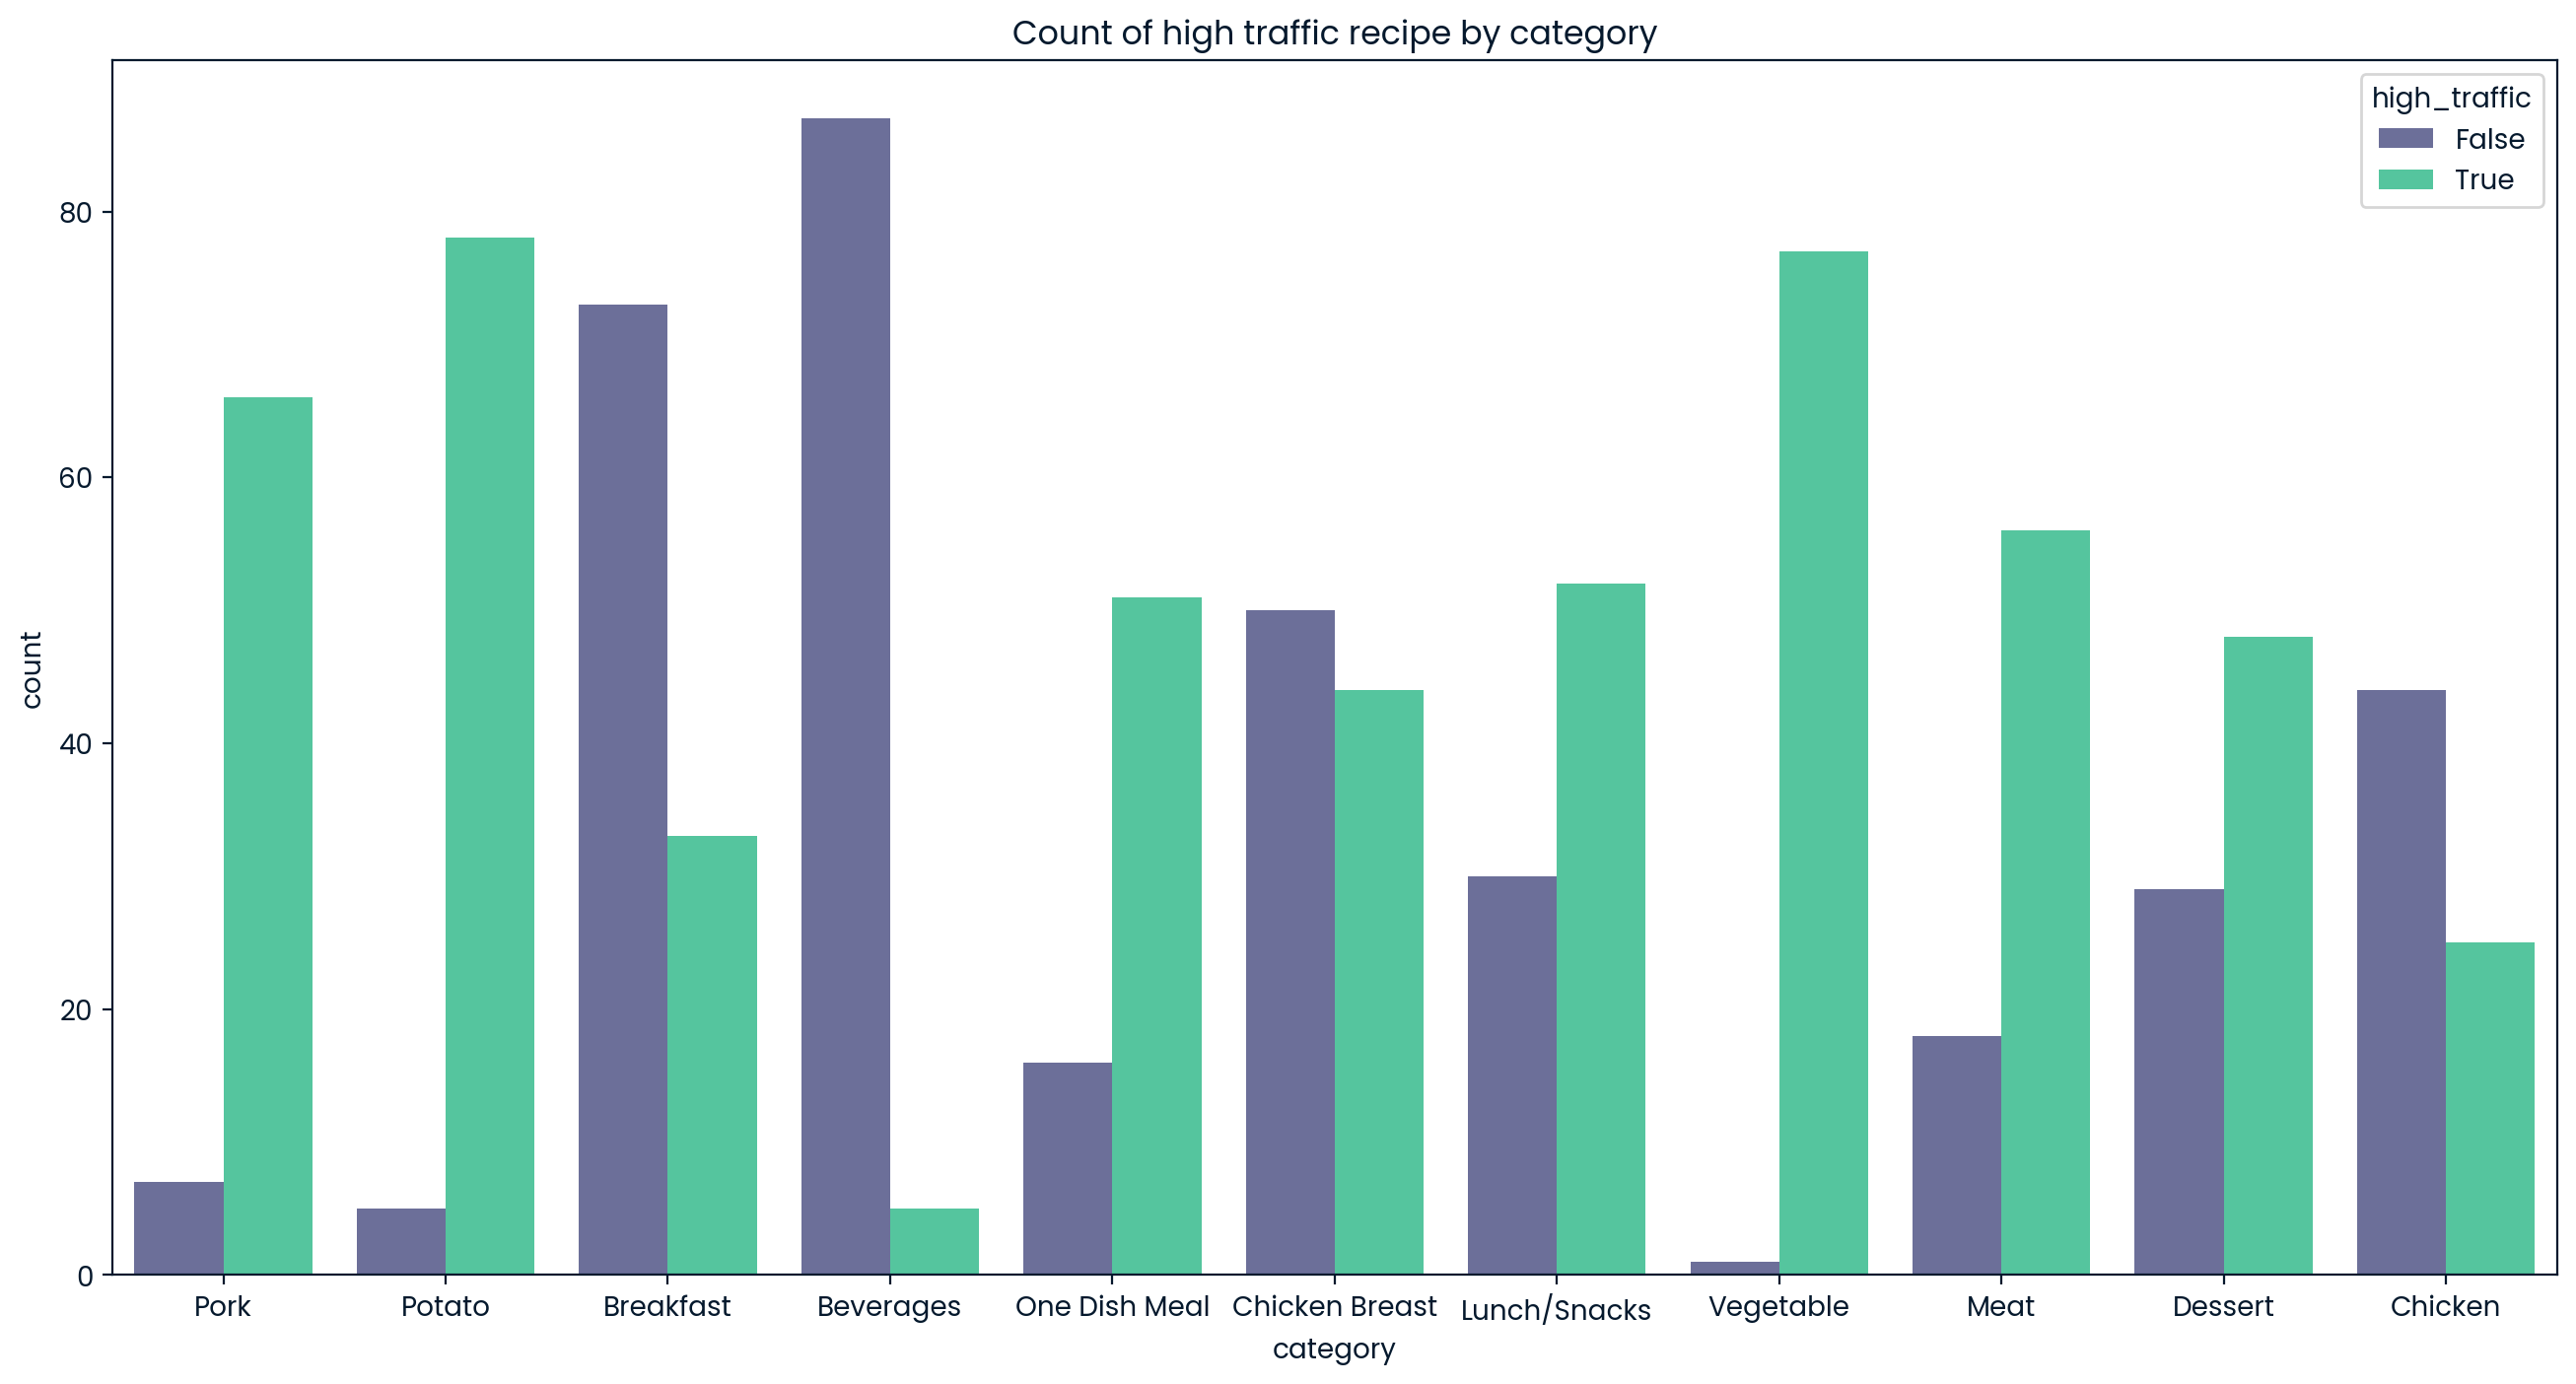

In [47]:
# plot high traffic vs category

plt.figure(figsize=(16, 8))
sns.countplot( x = 'category', hue='high_traffic', data = recipe_df_cat)
plt.title("Count of high traffic recipe by category")
plt.show()

In [48]:
# Group by high_trafic to show how categories distributed

high_traffic_servings = pd.pivot_table(recipe_df_cat, index=["category"], columns=["high_traffic"], values="calories", aggfunc='count')
high_traffic_servings_normalized = high_traffic_servings.div(high_traffic_servings.sum(axis=1), axis=0)

print(high_traffic_servings_normalized)

high_traffic       False     True 
category                          
Pork            0.095890  0.904110
Potato          0.060241  0.939759
Breakfast       0.688679  0.311321
Beverages       0.945652  0.054348
One Dish Meal   0.238806  0.761194
Chicken Breast  0.531915  0.468085
Lunch/Snacks    0.365854  0.634146
Vegetable       0.012821  0.987179
Meat            0.243243  0.756757
Dessert         0.376623  0.623377
Chicken         0.637681  0.362319


The top three categories—"Vegetable," "Potato," and "Pork"—are frequently observed during high traffic periods. On the other hand, the "Beverages" category shows the lowest association with high traffic.

However, due to the imbalance in the data distribution, I cannot conclude that these categories directly influence high traffic. The frequency of observations may be a result of the data imbalance rather than an actual impact. 

I will take this into account when selecting models, focusing on those that are more robust to data imbalance.


# 3.Model Development
My solution uses binary classification to identify high-traffic recipes through supervised machine learning techniques. I am considering Logistic Regression, Decision Tree, Random Forest, and Support Vector Machines for this task.

Before proceeding with modeling, I will address the issue of outliers in the dataset. To manage outliers effectively, I’ll calculate the Interquartile Range (IQR) for each column and use it to set upper and lower boundaries.

I will also account for class imbalance when deploying my models. For instance, I’ll enable the 'balanced' parameter in models that support it to improve results.

For robust model evaluation, I will split the data into training and testing sets to validate performance accurately.



## 3.1 Transformation for Outlier and Skewness

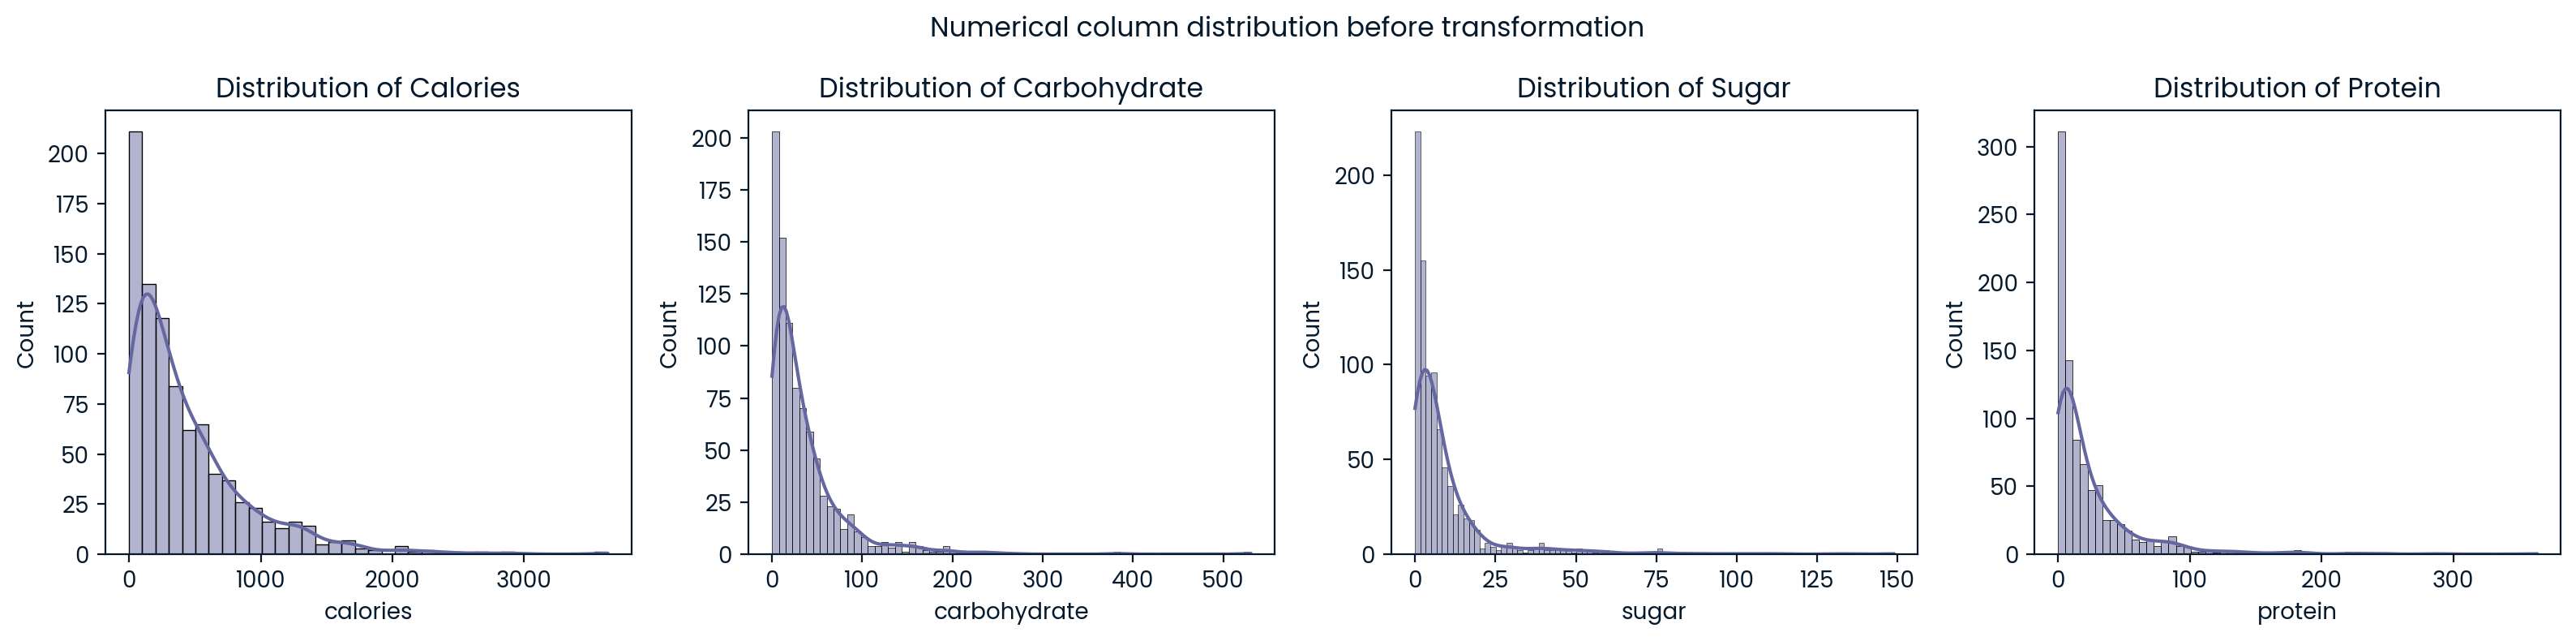

In [49]:

# Specifying the numerical columns to plot
numerical_columns =  recipe_df_cat.select_dtypes(include='float').columns

plt.figure(figsize=(16, 4))

#iterating over each column and create a bar plot
for i, column in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    sns.histplot(data=recipe_df_cat, x=column, kde=True)
    plt.title(f"Distribution of {column.capitalize()}")

plt.suptitle('Numerical column distribution before transformation')
plt.tight_layout()
plt.show()

To tackle the issue of outliers within our dataset, I compute the Interquartile Range (IQR) for each column and subsequently determine the upper and lower boundaries to manage the outliers more effectively

In [50]:
#function to calculate upper and lower boundaries of columns
def calculate_outlier_limits(data, factor=1.5):
    # Find 25% and 75% percentiles
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    
    #calculate IQR
    iqr = q3 - q1
    
    #calculate lower and upper boundaries
    lower_limit = q1 - (factor * iqr)
    upper_limit = q3 + (factor * iqr)
    return lower_limit, upper_limit

In [51]:
#select numerical columns
numerical_columns = ['calories', 'carbohydrate', 'sugar', 'protein']

#calculate outlier limits for each numerical column
outlier_limits = {}
for column in numerical_columns:
    lower_limit, upper_limit = calculate_outlier_limits(recipe_df_cat[column])
    outlier_limits[column] = (lower_limit, upper_limit)

#check the calculated outlier limits for each column
for column, limits in outlier_limits.items():
    print(f"Column: {column}")
    print(f"Lower Limit: {limits[0]}")
    print(f"Upper Limit: {limits[1]}")
    print("--------------------------------")

Column: calories
Lower Limit: -620.3999999999999
Upper Limit: 1328.48
--------------------------------
Column: carbohydrate
Lower Limit: -46.510000000000005
Upper Limit: 99.85000000000001
--------------------------------
Column: sugar
Lower Limit: -10.475000000000003
Upper Limit: 21.965000000000003
--------------------------------
Column: protein
Lower Limit: -37.31250000000001
Upper Limit: 70.70750000000001
--------------------------------


As anticipated, there are no concerns with respect to low values; however, certain high values require attention.
Various techniques are available to address this issue. Upon evaluation, it's apparent that outright removal of outliers leads to significant data loss, making this approach less favorable.
Similarly, capping outliers or using winsorization doesn't yield the desired distribution.

Through experimentation with diverse transformation methods including Logarithmic Transformation, Square Root Transformation, Yeo-Johnson Transformation, and Box-Cox Transformation, it has been determined that Box-Cox is the most effective approach.

Note that a few columns contain 0 values. While the Box-Cox Transformation could be used after replacing these 0 values with a very small value (e.g., 0.00001), such a replacement might introduce bias.

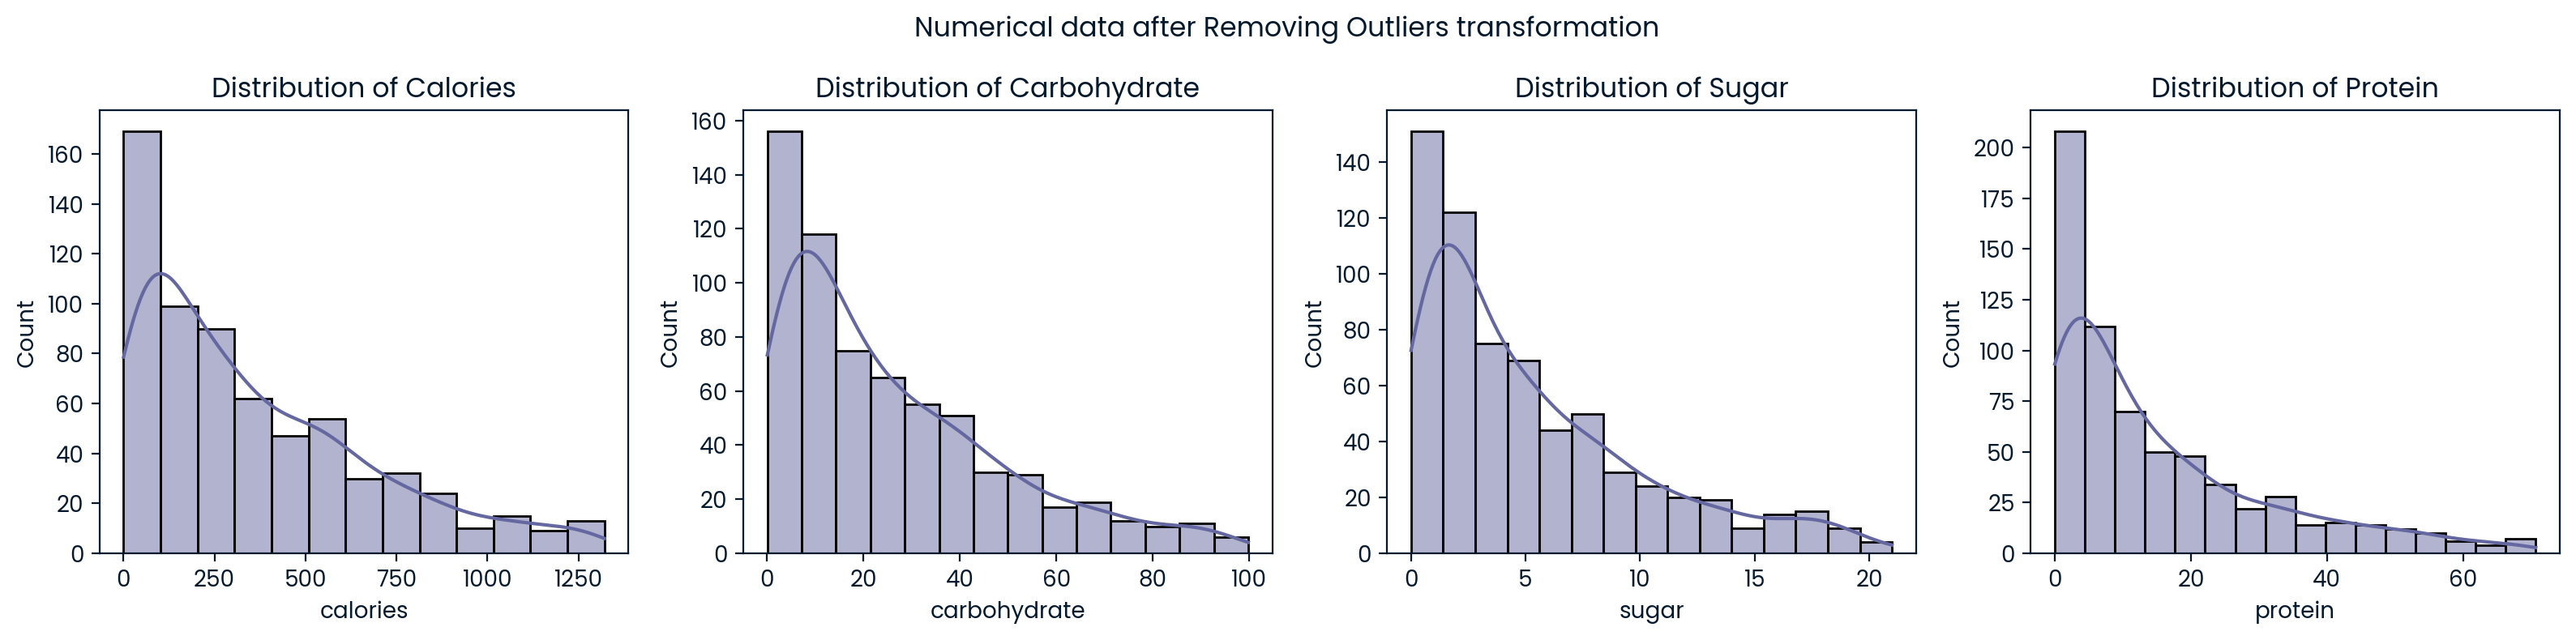

In [52]:

#filter the dataset based on the outlier limits
transformed_data = recipe_df_cat.copy()
for column, limits in outlier_limits.items():
    lower_limit, upper_limit = limits
    
    transformed_data = transformed_data[transformed_data[column] <= upper_limit]           # Removing Outliers

# Plotting transformmed data
plt.figure(figsize=(16, 4))

#iterating over each column and create a bar plot
for i, column in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    sns.histplot(data=transformed_data, x=column, kde=True)
    plt.title(f"Distribution of {column.capitalize()}")

plt.suptitle('Numerical data after Removing Outliers transformation')
plt.tight_layout()
plt.show()

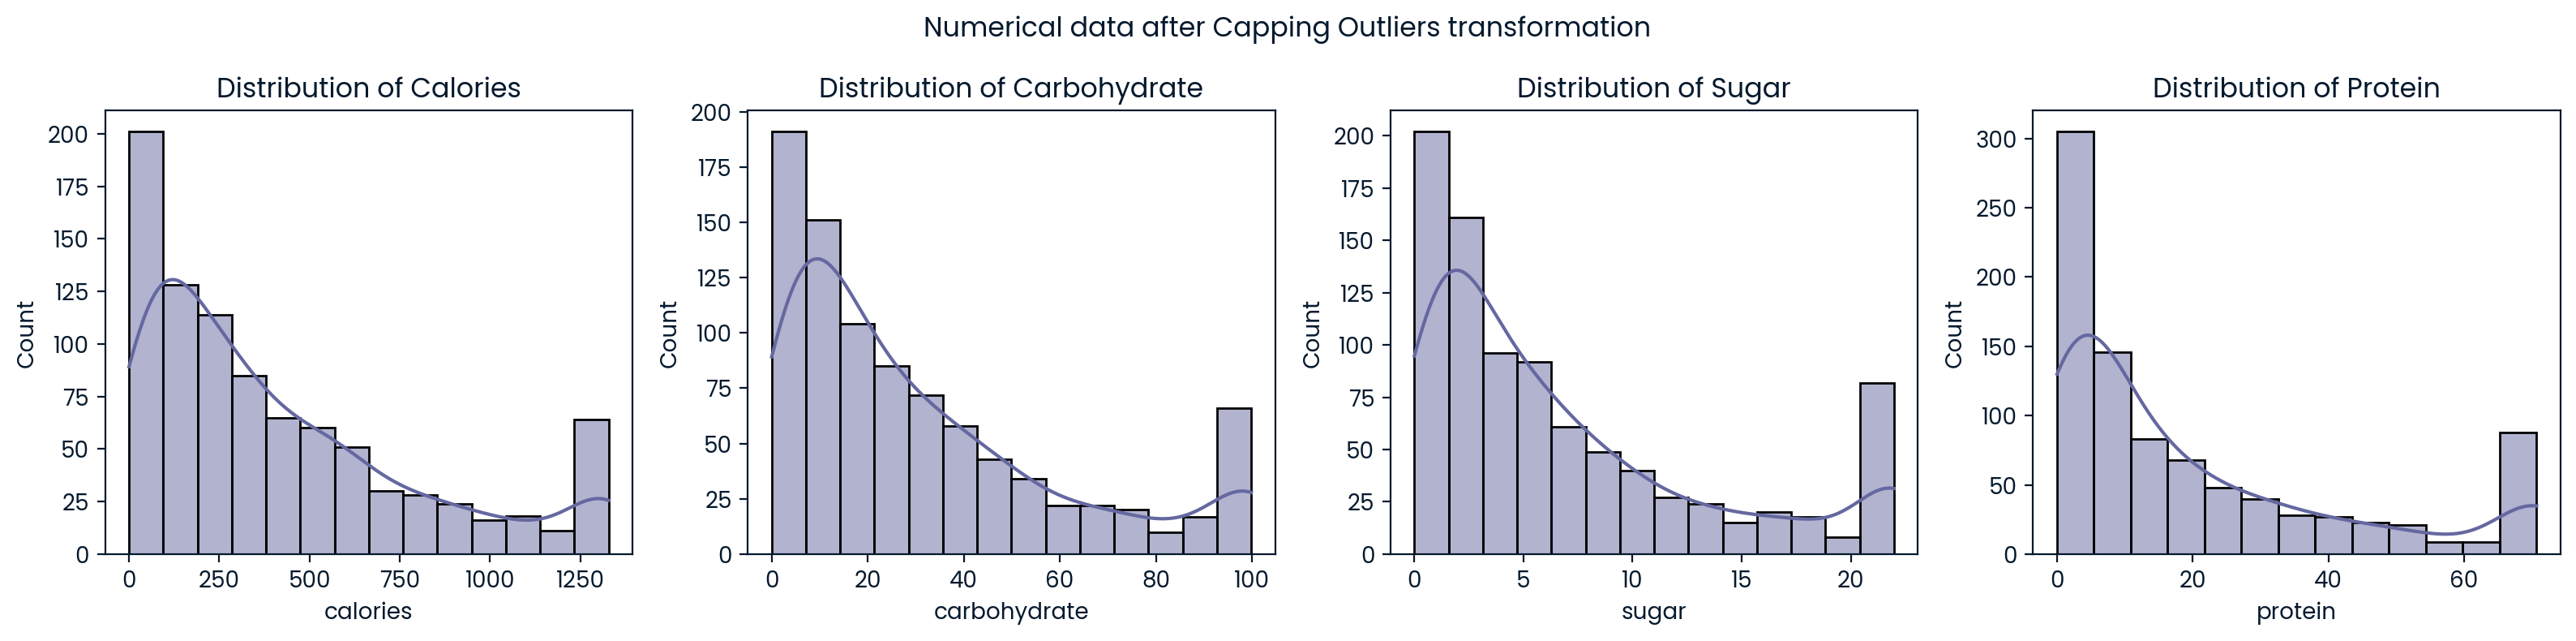

In [53]:
#filter the dataset based on the outlier limits
transformed_data = recipe_df_cat.copy()
for column, limits in outlier_limits.items():
    lower_limit, upper_limit = limits
    
    transformed_data[column] = transformed_data[column].clip(upper=upper_limit)            # Capping Outliers
# Plotting transformmed data
plt.figure(figsize=(16, 4))

#iterating over each column and create a bar plot
for i, column in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    sns.histplot(data=transformed_data, x=column, kde=True)
    plt.title(f"Distribution of {column.capitalize()}")

plt.suptitle('Numerical data after Capping Outliers transformation')
plt.tight_layout()
plt.show()

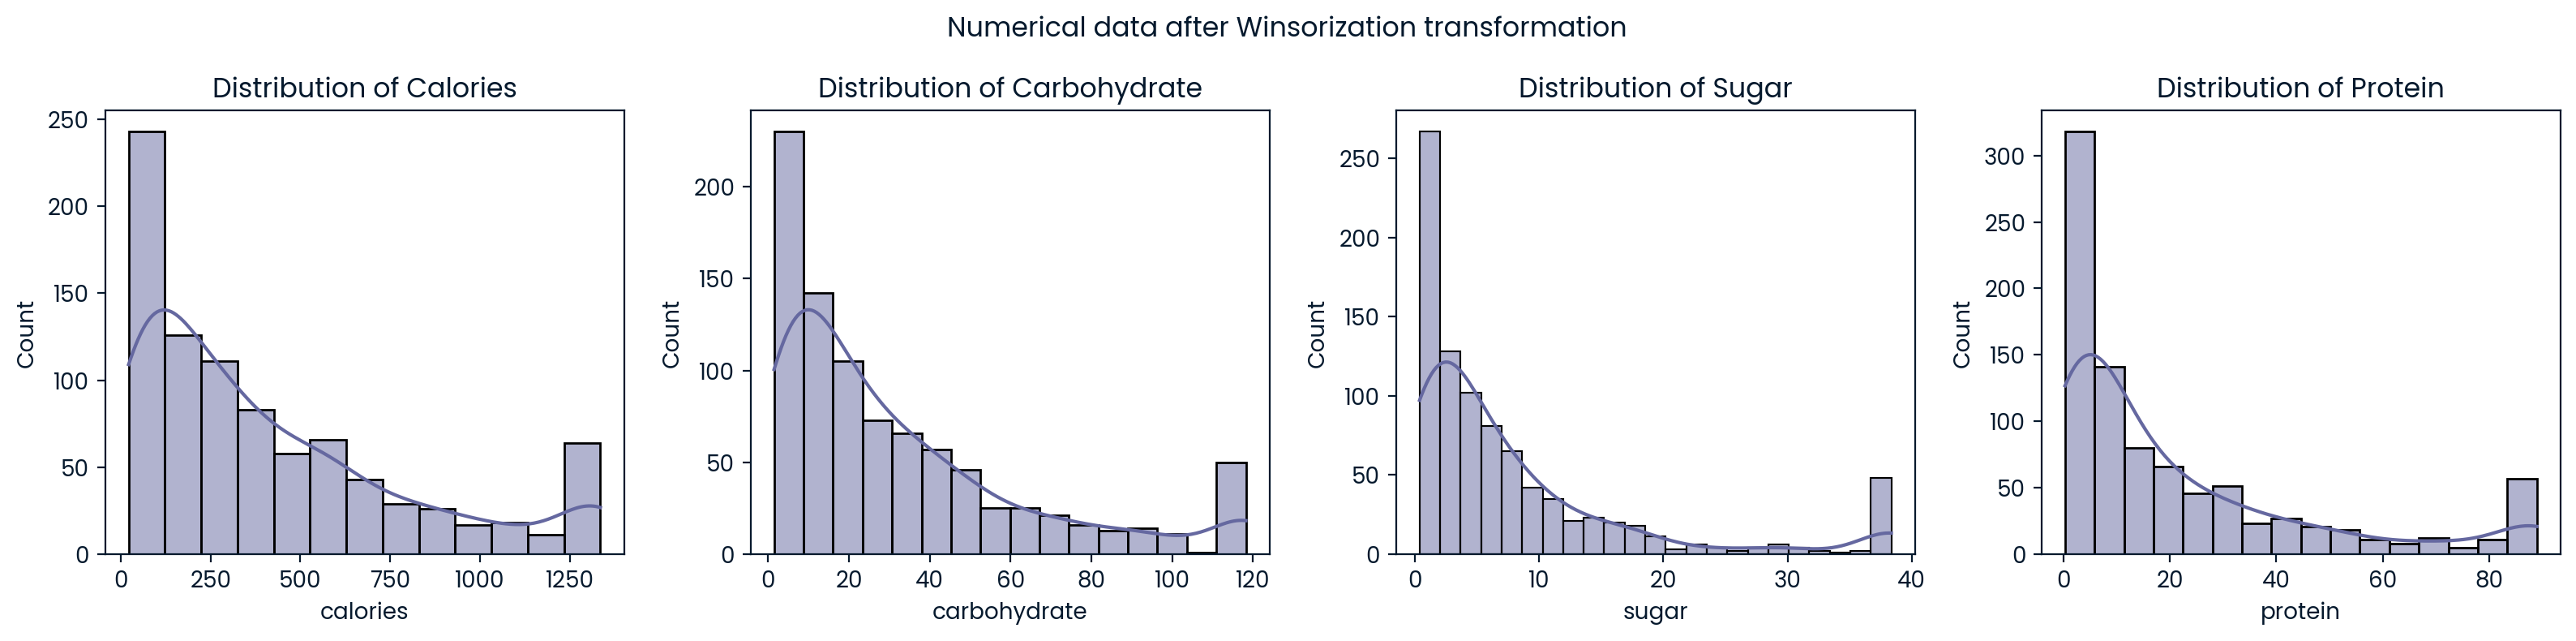

In [54]:
#filter the dataset based on the outlier limits

transformed_data = recipe_df_cat.copy()
for column, limits in outlier_limits.items():
    lower_limit, upper_limit = limits
    
    transformed_data[column] = winsorize(transformed_data[column], limits=[0.05, 0.05])    # Winsorization

# Plotting transformmed data
plt.figure(figsize=(16, 4))

#iterating over each column and create a bar plot
for i, column in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    sns.histplot(data=transformed_data, x=column, kde=True)
    plt.title(f"Distribution of {column.capitalize()}")

plt.suptitle('Numerical data after Winsorization transformation')
plt.tight_layout()
plt.show()

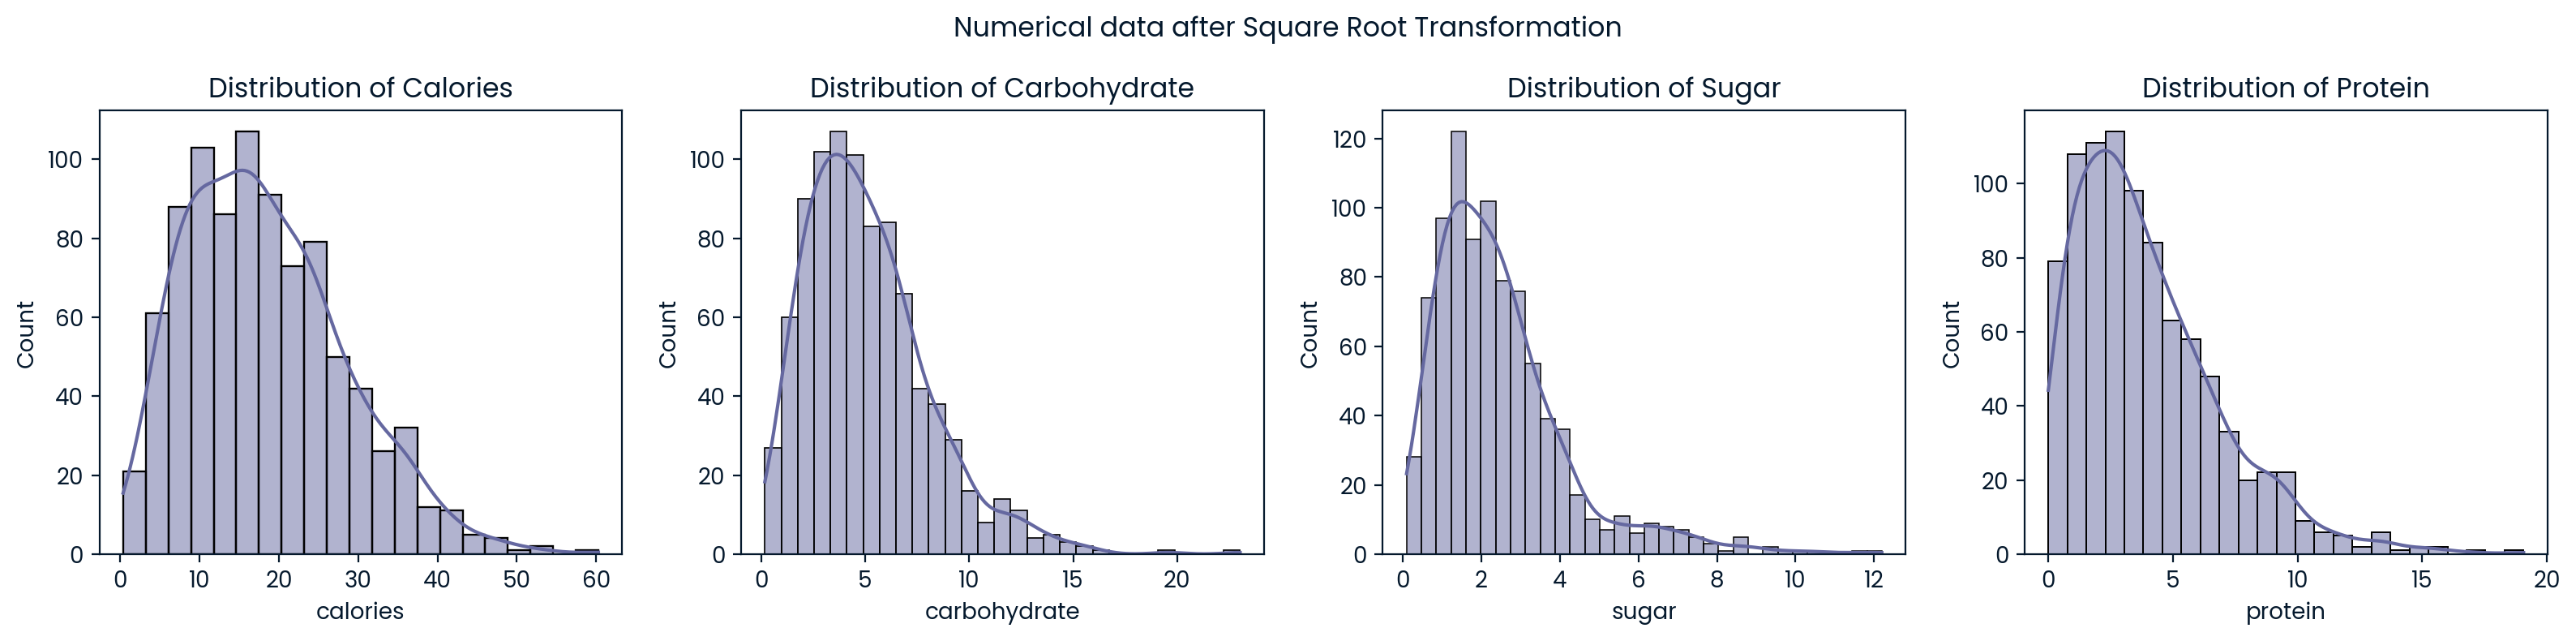

In [55]:
#filter the dataset based on the outlier limits
transformed_data = recipe_df_cat.copy()
for column, limits in outlier_limits.items():
    lower_limit, upper_limit = limits
    
    transformed_data[column] = np.sqrt(transformed_data[column])                           # Square Root Transformation
# Plotting transformmed data
plt.figure(figsize=(16, 4))

#iterating over each column and create a bar plot
for i, column in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    sns.histplot(data=transformed_data, x=column, kde=True)
    plt.title(f"Distribution of {column.capitalize()}")

plt.suptitle('Numerical data after Square Root Transformation')
plt.tight_layout()
plt.show()

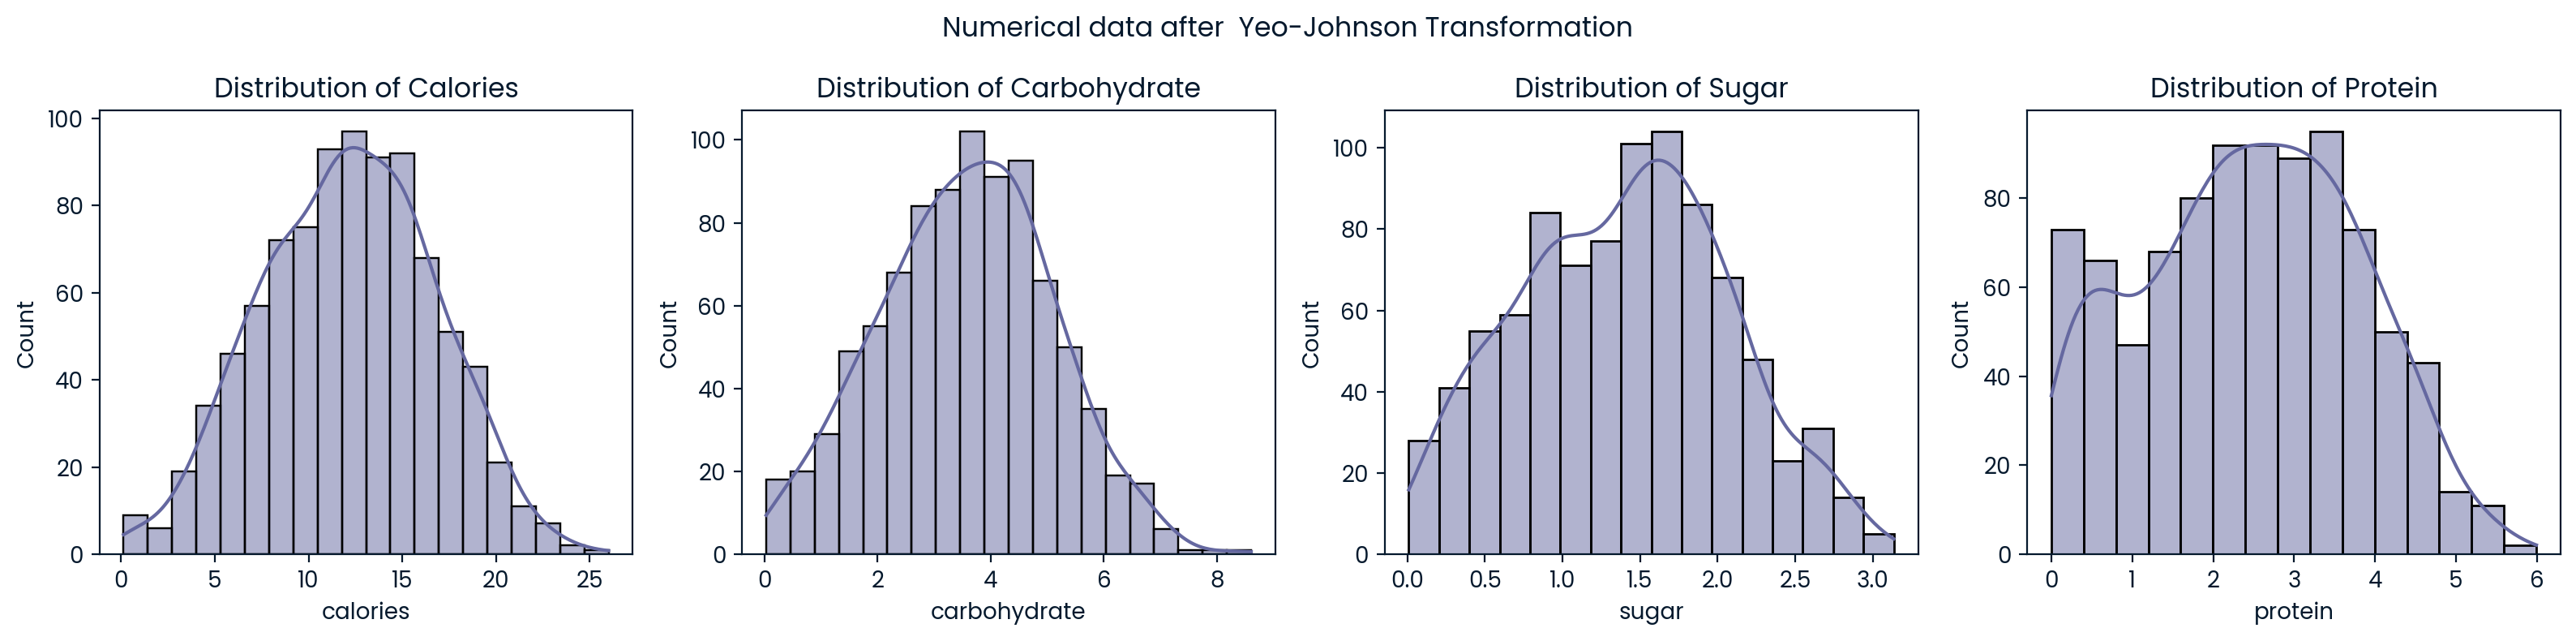

In [56]:
#filter the dataset based on the outlier limits
transformed_data = recipe_df_cat.copy()
for column, limits in outlier_limits.items():
    lower_limit, upper_limit = limits

    transformed_data[column] = yeojohnson(transformed_data[column])[0]                      # Yeo-Johnson Transformation

# Plotting transformmed data
plt.figure(figsize=(16, 4))

#iterating over each column and create a bar plot
for i, column in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    sns.histplot(data=transformed_data, x=column, kde=True)
    plt.title(f"Distribution of {column.capitalize()}")

plt.suptitle('Numerical data after  Yeo-Johnson Transformation')
plt.tight_layout()
plt.show()

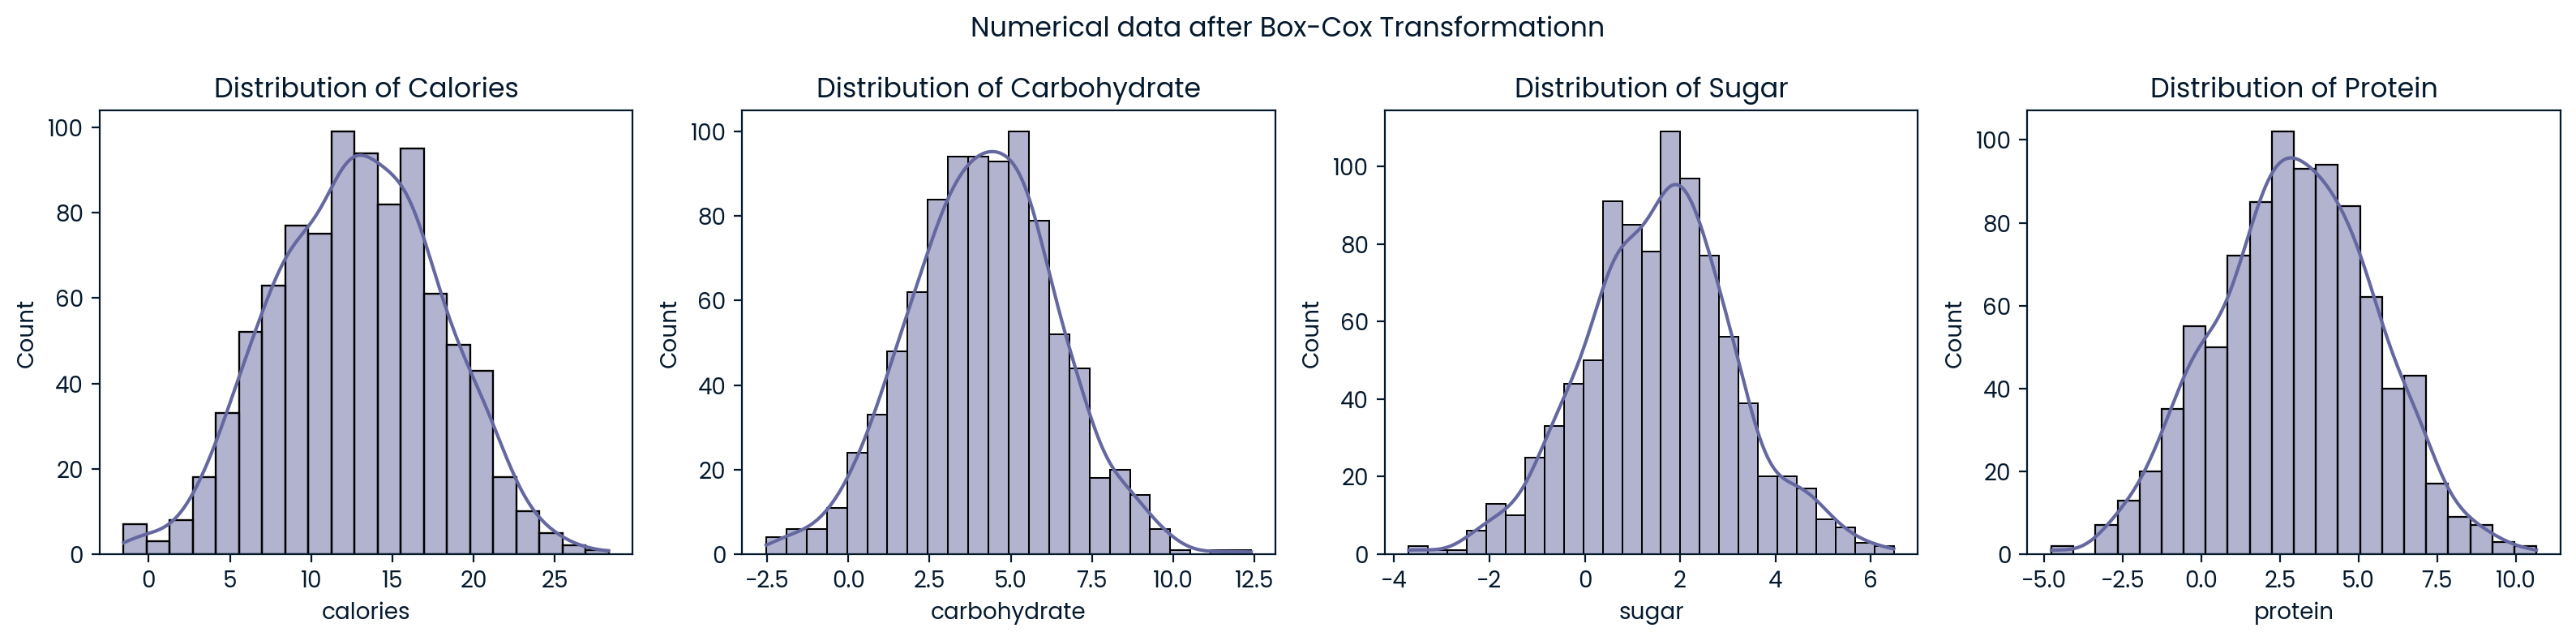

In [57]:
#filter the dataset based on the outlier limits

transformed_data = recipe_df_cat.copy()
for column, limits in outlier_limits.items():
    lower_limit, upper_limit = limits

    transformed_data.loc[transformed_data[column] == 0, column] = 0.00001
    transformed_data[column] = boxcox(transformed_data[column])[0]                         # Box-Cox Transformation

# Plotting transformmed data
plt.figure(figsize=(16, 4))

#iterating over each column and create a bar plot
for i, column in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    sns.histplot(data=transformed_data, x=column, kde=True)
    plt.title(f"Distribution of {column.capitalize()}")

plt.suptitle('Numerical data after Box-Cox Transformationn')
plt.tight_layout()
plt.show()

## 3.2 Encoding Categorical Data 
I use One-Hot Encodin to Convert categorical features into binary vectors.

In [58]:
#performing one-hot encoding on the category column
encoded_categories = pd.get_dummies(recipe_df_cat["category"])

#concatenate the encoded categories with the original dataframe
recipe_df_encoded = pd.concat([transformed_data, encoded_categories], axis=1)

#drop the original category column
recipe_df_encoded = recipe_df_encoded.drop("category", axis=1)
recipe_df_encoded.head()

,calories,carbohydrate,sugar,protein,servings,high_traffic,Pork,Potato,Breakfast,Beverages,One Dish Meal,Chicken Breast,Lunch/Snacks,Vegetable,Meat,Dessert,Chicken
0,5.861317,5.349463,-0.407034,-0.082744,4,True,0,1,0,0,0,0,0,0,0,0,0
1,18.656633,5.560178,1.194001,1.168001,1,False,0,0,1,0,0,0,0,0,0,0,0
2,8.749556,4.882417,4.407580,-2.786981,4,True,0,0,0,1,0,0,0,0,0,0,0
3,5.202664,0.654060,-0.220682,-0.599124,4,False,0,0,0,1,0,0,0,0,0,0,0
4,17.086019,1.406394,0.513475,5.890263,2,True,0,0,0,0,1,0,0,0,0,0,0


## 3.3 Model Selection and Deployment
Addressing this problem involves leveraging binary classification algorithms from the realm of supervised machine learning. We have the option to select an appropriate classification model to predict high traffic status. Viable choices include Logistic Regression, Decision Tree, Random Forest, or Support Vector Machines.
For our baseline model, we'll opt for Logistic Regression due to its simplicity, interpretability, and efficiency for binary classification tasks. Logistic Regression provides clear insights into the influence of independent variables on the predicted probability of high traffic, making it easier to explain results to stakeholders.

Next, we will consider Decision Trees, which are advantageous for their intuitive visual representation and ability to handle both numerical and categorical data. They also allow for non-linear relationships between features and the target variable.

Random Forest will be another option, as it combines multiple decision trees to enhance predictive performance and reduce overfitting. This ensemble method is robust and often provides high accuracy, making it a reliable choice for complex datasets.

Finally, Support Vector Machines (SVM) will be considered due to their effectiveness in high-dimensional spaces and their ability to model complex decision boundaries. SVMs can be particularly powerful when dealing with smaller datasets or when the classes are not linearly separable.

By evaluating these models, we can identify the most suitable approach for predicting high traffic status, balancing interpretability and performance.
I split the data into features (X) and the target variable (y), where the target variable is the "high_traffic" column. Next, I divided the data into training and testing sets using the train_test_split function from the scikit-learn library. I developed both a baseline model and comparison models to evaluate performance. The chosen model was fit on the training data, and predictions were made on the testing data. Additionally, the predict method was used on the trained model to assess potential overfitting.



Since this is a binary classification problem and the goal is to correctly predict high traffic recipes 80% of the time, precision will be my target metric. Given that the dataset only contains information about observed high traffic, with no explicit data on low traffic, focusing on precision makes sense.

In [59]:
# splitting data into features X and target y
X = recipe_df_encoded.drop("high_traffic", axis=1)
y = recipe_df_encoded["high_traffic"]
# Feature engineering

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [60]:
#create function to fit the model, make prediction, and return evaluation metrics
def develop_model(model, X_train, y_train, X_test, y_test):
    evaulation_metrics = {}

    #fit the model
    model.fit(X_train, y_train)

    #predict for train and test data
    model_pred_train = model.predict(X_train)
    model_pred_test = model.predict(X_test)

    #find evaluation parameters for train data
    model_accuracy_train = accuracy_score(y_train, model_pred_train)
    model_precision_train = precision_score(y_train, model_pred_train)
    model_recall_train = recall_score(y_train, model_pred_train)
    model_f1_train = f1_score(y_train, model_pred_train)
    model_confusion_matrix_train = confusion_matrix(y_train, model_pred_train)
   
    
    evaulation_metrics['train'] = {'Accuracy': model_accuracy_train, 'Precision': model_precision_train, 'Recall': model_recall_train, 'F1Score': model_f1_train, 'Confusion_matrix': model_confusion_matrix_train}

    #find evaluation parameters for test data
    model_accuracy_test = accuracy_score(y_test, model_pred_test)
    model_precision_test = precision_score(y_test, model_pred_test)
    model_recall_test = recall_score(y_test, model_pred_test)
    model_f1_test = f1_score(y_test, model_pred_test)
    model_cm_test = confusion_matrix(y_test, model_pred_test)
    model_confusion_matrix_test = confusion_matrix(y_test, model_pred_test)
    
    evaulation_metrics['test'] = {'Accuracy': model_accuracy_test, 'Precision': model_precision_test, 'Recall': model_recall_test, 'F1Score': model_f1_test, 'Confusion_matrix':model_confusion_matrix_test }
    

    return evaulation_metrics

In [61]:
#decision tree
dtree = DecisionTreeClassifier(class_weight='balanced')
dtree_evaluation_metrics = develop_model(dtree, X_train, y_train, X_test, y_test)

In [62]:
dtree_evaluation_metrics

{'train': {'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1Score': 1.0,
  'Confusion_matrix': array([[298,   0],
         [  0, 418]])},
 'test': {'Accuracy': 0.6983240223463687,
  'Precision': 0.8,
  'Recall': 0.717948717948718,
  'F1Score': 0.7567567567567569,
  'Confusion_matrix': array([[41, 21],
         [33, 84]])}}

In [63]:
#logistic regression
logreg = LogisticRegression(class_weight='balanced')
logreg_evaluation_metrics = develop_model(logreg, X_train, y_train, X_test, y_test)

In [64]:
logreg_evaluation_metrics

{'train': {'Accuracy': 0.7458100558659218,
  'Precision': 0.7906403940886699,
  'Recall': 0.7679425837320574,
  'F1Score': 0.779126213592233,
  'Confusion_matrix': array([[213,  85],
         [ 97, 321]])},
 'test': {'Accuracy': 0.8100558659217877,
  'Precision': 0.8608695652173913,
  'Recall': 0.8461538461538461,
  'F1Score': 0.8534482758620691,
  'Confusion_matrix': array([[46, 16],
         [18, 99]])}}

In [65]:
#random forest
rf = RandomForestClassifier(class_weight='balanced')
rf_evaluation_metrics = develop_model(rf, X_train, y_train, X_test, y_test)

In [66]:
rf_evaluation_metrics

{'train': {'Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1Score': 1.0,
  'Confusion_matrix': array([[298,   0],
         [  0, 418]])},
 'test': {'Accuracy': 0.776536312849162,
  'Precision': 0.8347826086956521,
  'Recall': 0.8205128205128205,
  'F1Score': 0.8275862068965518,
  'Confusion_matrix': array([[43, 19],
         [21, 96]])}}

In [67]:
#support vector machines
svc = SVC(class_weight='balanced')
svc_evaluation_metrics = develop_model(svc, X_train, y_train, X_test, y_test)

In [75]:
svc_evaluation_metrics

{'train': {'Accuracy': 0.6731843575418994,
  'Precision': 0.6678832116788321,
  'Recall': 0.8755980861244019,
  'F1Score': 0.7577639751552796,
  'Confusion_matrix': array([[116, 182],
         [ 52, 366]])},
 'test': {'Accuracy': 0.7150837988826816,
  'Precision': 0.7291666666666666,
  'Recall': 0.8974358974358975,
  'F1Score': 0.8045977011494253,
  'Confusion_matrix': array([[ 23,  39],
         [ 12, 105]])}}

I created an instance of each model with class_weight='balanced' to address the class imbalance in the dataset.

## 3.4 Model Evaluation

In [69]:

# concanting all result into one table


SVC_result = pd.DataFrame(svc_evaluation_metrics)
RF_result = pd.DataFrame(rf_evaluation_metrics)
Log_reg_result = pd.DataFrame(logreg_evaluation_metrics)
DT_result = pd.DataFrame(dtree_evaluation_metrics)
Final_result = pd.concat([SVC_result,RF_result], axis = 0)
Final_result = pd.concat([Final_result,Log_reg_result], axis = 0)
Final_result = pd.concat([Final_result,DT_result], axis = 0)


# Convert the index to a column
Final_result.reset_index(inplace=True)

# Define a new categorical column to serve as the index
Final_result['model'] = ['SVC','SVC','SVC','SVC','SVC', 'RF', 'RF', 'RF', 'RF', 'RF', 'Log_reg', 'Log_reg', 'Log_reg', 'Log_reg', 'Log_reg','DT','DT','DT','DT','DT']  # Example categories

# Convert the new column to a categorical type
Final_result['model'] = pd.Categorical(Final_result['model'])

# Set the new categorical column as the index
Final_result.set_index('model', inplace=True)


Final_result

,index,train,test
model,,,
SVC,Accuracy,0.673184,0.715084
SVC,Precision,0.667883,0.729167
SVC,Recall,0.875598,0.897436
SVC,F1Score,0.757764,0.804598
SVC,Confusion_matrix,"[[116, 182], [52, 366]]","[[23, 39], [12, 105]]"
RF,Accuracy,1.0,0.776536
RF,Precision,1.0,0.834783
RF,Recall,1.0,0.820513
RF,F1Score,1.0,0.827586


Logistic regression reached the goal on the test data to improve the result to get closer to the target of 80% I will run some fine tuning of the model.

**Log_reg:** model does not exhibit significant signs of overfitting. The performance on the training data is good, and the metrics on the test data are even better, indicating it generalizes well to unseen data.

Given that the objective is to achieve an 80% accuracy in predicting high traffic recipes, it's essential to examine the precision metrics, which stands at 83.34%. This precision score aligns with the goal of correctly predicting high traffic recipes 80% of the time.

**DT:** The Decision Tree model, being robust in nature, has demonstrated an instance of overfitting due to the low number of observations within the dataset. This overfitting indicates that the model has essentially memorised the training data, rendering it unsuitable for our specific dataset.

It's important to note that various techniques, including strategies like Increasing Training Data, Regularisation, and Cross-Validation, can be employed to address overfitting. However, considering the limited data available, these techniques may not yield the desired outcome.

In light of these considerations, the Decision Tree model may not be the best fit for our dataset due to its overfitting tendencies.


**RF:** The accuracy of approximately 77% is considerably lower than the 100% accuracy achieved on the training dataset, indicating that the model does not generalize well to unseen data. The precision (83%) and recall (81%) are also lower than perfect, suggesting that the model has room for improvement in distinguishing between high-traffic and low-traffic recipes. The significant drop in performance metrics from the training data (100% across the board) to the test data (77% accuracy) strongly indicates that the model is overfitting. It has learned the training data too well, including its noise, rather than the underlying patterns.

In this case, even though the precision score aligns with our goal, the overfitting issue precludes us from utilizing the Random Forest model effectively.

**SVC:** Given the high recall and low precision on training data, combined with a drop in accuracy and precision on the test data, the model might be overfitting. It appears to have learned to identify high-traffic recipes very well but is generalizing poorly to low-traffic recipes.

## 3.5 Fine tuning of the model

I decided to fine-tune the models using a pipeline and grid search to find the best parameters and confirm that logistic regression is the best model for prediction.

In [70]:
# Store the initialised model in a dictionary
models = { "LogisticRegression" : LogisticRegression(class_weight='balanced'),
          "KNeighborsClassifier" : KNeighborsClassifier(),
          "DecisionTreeClassifier" : DecisionTreeClassifier(class_weight='balanced'),
          "RandomForestClassifier" : RandomForestClassifier(class_weight='balanced'),
          "SVC": SVC(class_weight='balanced')
}

# Store model parameters in a dictionary

param_grid = {
    "LogisticRegression" : {"LogisticRegression__C" : [0.01, 0.1, 1,10]},
    "KNeighborsClassifier" : {"KNeighborsClassifier__n_neighbors" : range(1,10)},
    "DecisionTreeClassifier": {"DecisionTreeClassifier__max_depth":[2,5,10],
                             "DecisionTreeClassifier__min_samples_split" : [2,5,10,20],
                             "DecisionTreeClassifier__random_state":[42]},
    "RandomForestClassifier": {"RandomForestClassifier__n_estimators": [50,100, 150, 200]},
    "SVC" : {"SVC__kernel" : ['linear', 'poly', 'rbf', 'sigmoid']}
    
}

In [71]:
pipe_precision = {}
pipe_params = {}
pipelines = {}

# Iterative process to find the best model parameters
for name, model in models.items():
    pipeline = Pipeline(steps=[(name, model)])  
    grid_search = GridSearchCV(pipeline, param_grid[name], scoring="precision")
    
    grid_search.fit(X_train,y_train)
    pipe_precision[name] = grid_search.best_score_
    pipe_params[name] = grid_search.best_params_
    pipelines[name] = grid_search 

best_model_name =  max(pipe_precision, key=pipe_precision.get)
best_model_cv_score = max(pipe_precision.values())
best_model_info = pipe_params[best_model_name]

print(f"Best Model : {best_model_name}")
print(f"Best Model Parameters : {best_model_info}")
print(f"Best Model CV Score : {best_model_cv_score}")

Best Model : LogisticRegression
Best Model Parameters : {'LogisticRegression__C': 10}
Best Model CV Score : 0.7904516852836447


We got closer to 80% on the train data and the results from test data confims 80% precsion has reached.

## 3.6 Final Validation

To confirm that 80% precision on unseen data has been reached using logistic regression.

In [72]:
y_pred = pipelines[best_model_name].predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.81
Precision: 0.86
Recall: 0.85
F1 Score: 0.85


# 4.Business Metrics

Since we are focusing on the detection of high traffic in a binary classification scenario, where low traffic is not observed, we need to ensure that true high traffic instances are detected accurately.

We can establish a Key Performance Indicator (KPI) by dividing True Positives (high traffic correctly classified as high) by False Positives (low traffic mistakenly classified as high) within the confusion matrix. This KPI, which we can refer to as the "High Traffic Conversion Rate," should be maintained at a level equal to or greater than 5.0, based on the training and testing results of our baseline model. This KPI will serve as a valuable metric for our business model, providing insights into the accuracy of high traffic predictions.


In [73]:
# KPI calculation
def calculate_kpi(model_metrics, model_name):
    kpi_train = model_metrics['train']['Confusion_matrix']
    kpi_test = model_metrics['test']['Confusion_matrix']
    print(f"High Traffic Conversion Rate for {model_name} train: ", kpi_train[1][1]/(kpi_train[0][1]))
    print(f"High Traffic Conversion Rate for {model_name} test: ", kpi_test[1][1]/(kpi_test[0][1]))

In [74]:
#KPI calculation for Logistic Regression
calculate_kpi(logreg_evaluation_metrics, "Logistic Regresssion")
print("-----------------------------------------------------------------------------------")

#KPI calculation for Decision Tree
calculate_kpi(dtree_evaluation_metrics, "Decision Tree")
print("-----------------------------------------------------------------------------------")

#KPI calculation for Random Forest
calculate_kpi(rf_evaluation_metrics, "Random Forest")
print("-----------------------------------------------------------------------------------")

#KPI calculation for Support Vector Machines
calculate_kpi(svc_evaluation_metrics, "Support Vector Machines")
print("-----------------------------------------------------------------------------------")

High Traffic Conversion Rate for Logistic Regresssion train:  3.776470588235294
High Traffic Conversion Rate for Logistic Regresssion test:  6.1875
-----------------------------------------------------------------------------------
High Traffic Conversion Rate for Decision Tree train:  inf
High Traffic Conversion Rate for Decision Tree test:  4.0
-----------------------------------------------------------------------------------
High Traffic Conversion Rate for Random Forest train:  inf
High Traffic Conversion Rate for Random Forest test:  5.052631578947368
-----------------------------------------------------------------------------------
High Traffic Conversion Rate for Support Vector Machines train:  2.010989010989011
High Traffic Conversion Rate for Support Vector Machines test:  2.6923076923076925
-----------------------------------------------------------------------------------


I decided to Keep the KPI threshold at 5.0 for broader inclusivity of model performance while encouraging improvements. If, over time, my models consistently meet or exceed this threshold, I will consider the potential to increase it to 6.0 to align with the higher-performing models.

In the training results of the Decision Tree and Random Forest models, the "KPI = inf" occurs due to overfitting. Furthermore, the test results for these models fall short of meeting our predetermined KPI requirement.

In both the training and testing results of the SVM model, underfitting contributes to the non-fulfillment of our KPI requirement.

Ultimately, in our baseline Logistic Regression model, both the training and testing results successfully adhere to our KPI requirement.'''

# 5.Summary

My efforts focused on the development and evaluation of multiple models to achieve my objectives. Among the various models created, the logistic regression model emerged as the most effective performer. This indicates that logistic regression is the optimal choice for predicting high-traffic recipes while achieving an accuracy of 80%.

From a business perspective, misclassifying a high-traffic recipe as low traffic is a more critical error than the reverse. Therefore, my primary focus is on model precision, as incorrectly predicting low traffic for a potentially high-traffic recipe can lead to significant losses for the business.

To support my analysis, I introduced a custom Key Performance Indicator (KPI) called "High Traffic Conversion Rate." This KPI was derived from the outcomes of my baseline model, allowing for meaningful comparisons among the developed models.

Additionally, my exploratory analysis revealed specific recipe categories that consistently generate high or low traffic. In particular, recipes categorized as "Vegetable," "Potato," or "Pork" tend to attract high traffic, making them strong candidates for inclusion on the website. Conversely, recipes categorized as "Beverages" generally result in low traffic, indicating that they may not be suitable for featuring on the platform.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation